## Importing modules

To import the hi-𝜒  module we need to provide the path to the locally compiled (C++) binaries and also to some primitive elements written in Python for convinience:

In [1]:
import sys
# all paths are relative to the current directory 'doc'
sys.path.append("../bin")
sys.path.append("../python_modules")

In [2]:
import pyHiChi as hichi

The *hichi_primitives* module contains some auxiliary Python functions and classes that will be used later.

In [3]:
import hichi_primitives as hp

To speed up the interaction between C++ and Python, we use the *Numpy* and *Namba* packages. *Numba* is an open source JIT compiler that can translate Python functions to optimized machine code and create compiled Python functions called from C++ code. The hi-chi module allows to use native Python functions, but pre-compilation speeds up the code execution by two orders of magnitude, as a rule.

In [4]:
import numpy as np

In [5]:
from numba import cfunc, float64, jit, njit, types, carray

The *time* module is necessary to take time measurements.

In [6]:
import time

To visualize the results, we use *matplotlib*.

In [7]:
import matplotlib
import matplotlib.pyplot as plt

## Setting the pulse to be focused

Let's set the next parameters of the spherical pulse. On the C ++ level, we use the CGS system of units, which should be taken into account when exporting some constants (for example, the light speed *hichi.c* is approximately equal to $3\cdot 10^{10}$ cm/s).

In [8]:
wavelength = 1.0  # the wavelength of the pulse [micron] (=1e-4 cm)
pulselength = 2.0*wavelength  # the pulse length
R0 = 16*wavelength  # the distance to the geometrical center
total_power = 1e7  # the peak power (over spherical surface) [erg/s] (= 1 W) 
f_number = 0.3  # f-number defines how tight the focusing is
opening_angle = np.arctan(1.0/(2.0*f_number))
edge_smoothing_angle = 0.1  # the angle over which
          # the transverse profile smoothly reaches zero at the edges [rad]

For convenience, the hi-chi module combines a field solver and a computational grid with properties corresponding to the solver into one entity called a 'field'. To create a field you need to specify the grid size, the spatial step of the grid, the start coordinates of a computational area, and the time step for performing the evolution of the electromagnetic field in time.

In [9]:
grid_size = hichi.Vector3d(256, 256, 256)
min_coords = hichi.Vector3d(-20, -20, -20)
max_coords = hichi.Vector3d(20, 20, 20)
grid_step = (max_coords - min_coords) / grid_size

In [10]:
time_step = R0*0.5/hichi.c

The following line creates the spectral field solver (**[link]**) and a grid instance for further calculations.

In [11]:
field = hichi.PSATDPoissonField(grid_size, min_coords, grid_step, time_step)

The *initialize_field()* function creates and returns compliled Python functions according to the longitudinal field variation $u_l$, the transverse shape $u_{ts}$, and the final field shape $u$ that defines spherical pulse. Also the *initialize_field()* function performs a computational grid initialisation.

To mark a function for optimization by Numba compiler it is enough to set *@njit* decorator above the function. To compile a function that can be called from C++ level, the *@cfunc* decorator is used. The *get_EM_field()* function takes 4 arguments: the first three arguments are the coordinates of the point, and the fourth one is a pointer to an array of 6 elements where the result will be written as a sequence of field values $E_x$, $E_y$, $E_z$, $B_x$, $B_y$, $B_z$.

In [12]:
def initialize_field(field, f_number_=f_number):
    
    opening_angle = np.arctan(1.0/(2.0*f_number_))
    amp = np.sqrt(total_power*4.0/(hichi.c*(1.0 - np.cos(opening_angle))))
    
    @njit
    def longitudinal_field_variation(x):  # u_l
         return np.sin(2*hichi.pi*x/wavelength) * \
                np.cos(hichi.pi*x/pulselength)**2 * \
                hp.block(x, -0.5*pulselength, 0.5*pulselength)
        
    @njit
    def transverse_shape(angle):  # u_ts
        angle1 = opening_angle - edge_smoothing_angle*0.5
        angle2 = opening_angle + edge_smoothing_angle*0.5
        return hp.block(angle, -1.0, angle1) + \
            (np.cos(0.5*hichi.pi*(angle - angle1)/edge_smoothing_angle)**2*\
             hp.block(angle, angle1, angle2) \
             if (not edge_smoothing_angle == 0.0) else 0.0)
               
    @njit
    def mask(x, y, z):  # u
        R = np.sqrt(x*x + y*y + z*z)
        if(R > 1e-5):
            angle = np.arcsin(np.sqrt(y*y + z*z)/R)
            return (amp/R) * longitudinal_field_variation(R - R0) * \
                                      transverse_shape(angle)*(x < 0)
        else: return 0.0
    
    # the following function is compiled to C++ and called from C++ level
    spec = "void(float64,float64,float64,types.CPointer(float64))"
    @cfunc(spec, nopython=True)
    def get_EM_field(x, y, z, field_arr_):
        p = hp.Vector3d(0.0, 1.0, 0.0)
        r = hp.Vector3d(x, y, z)
        s1 = hp.cross(p, r)
        s1.normalize()
        s0 = hp.cross(r, s1)
        s0.normalize()
        u = mask(x, y, z)
        field_arr = carray(field_arr_, (6))         
        field_arr[0] = u*s0.x  # Ex
        field_arr[1] = u*s0.y  # Ey
        field_arr[2] = u*s0.z  # Ez              
        field_arr[3] = u*s1.x  # Bx
        field_arr[4] = u*s1.y  # By
        field_arr[5] = u*s1.z  # Bz
    
    # the computational grid initialisation
    field.refresh()
    # the 'address' property is a pointer to the compiled function
    field.set(get_EM_field.address)
    
    return longitudinal_field_variation, transverse_shape, mask

In [13]:
longitudinal_field_variation, transverse_shape, mask = initialize_field(field)

Let's show the *longitudinal_field_variation()* and the *transverse_shape()* functions on the graph.

In [14]:
def plot_graph(X, Y, xlabel, ylabel, style="-b"):
    fig = plt.figure(dpi=500, figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(X, Y, style)
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

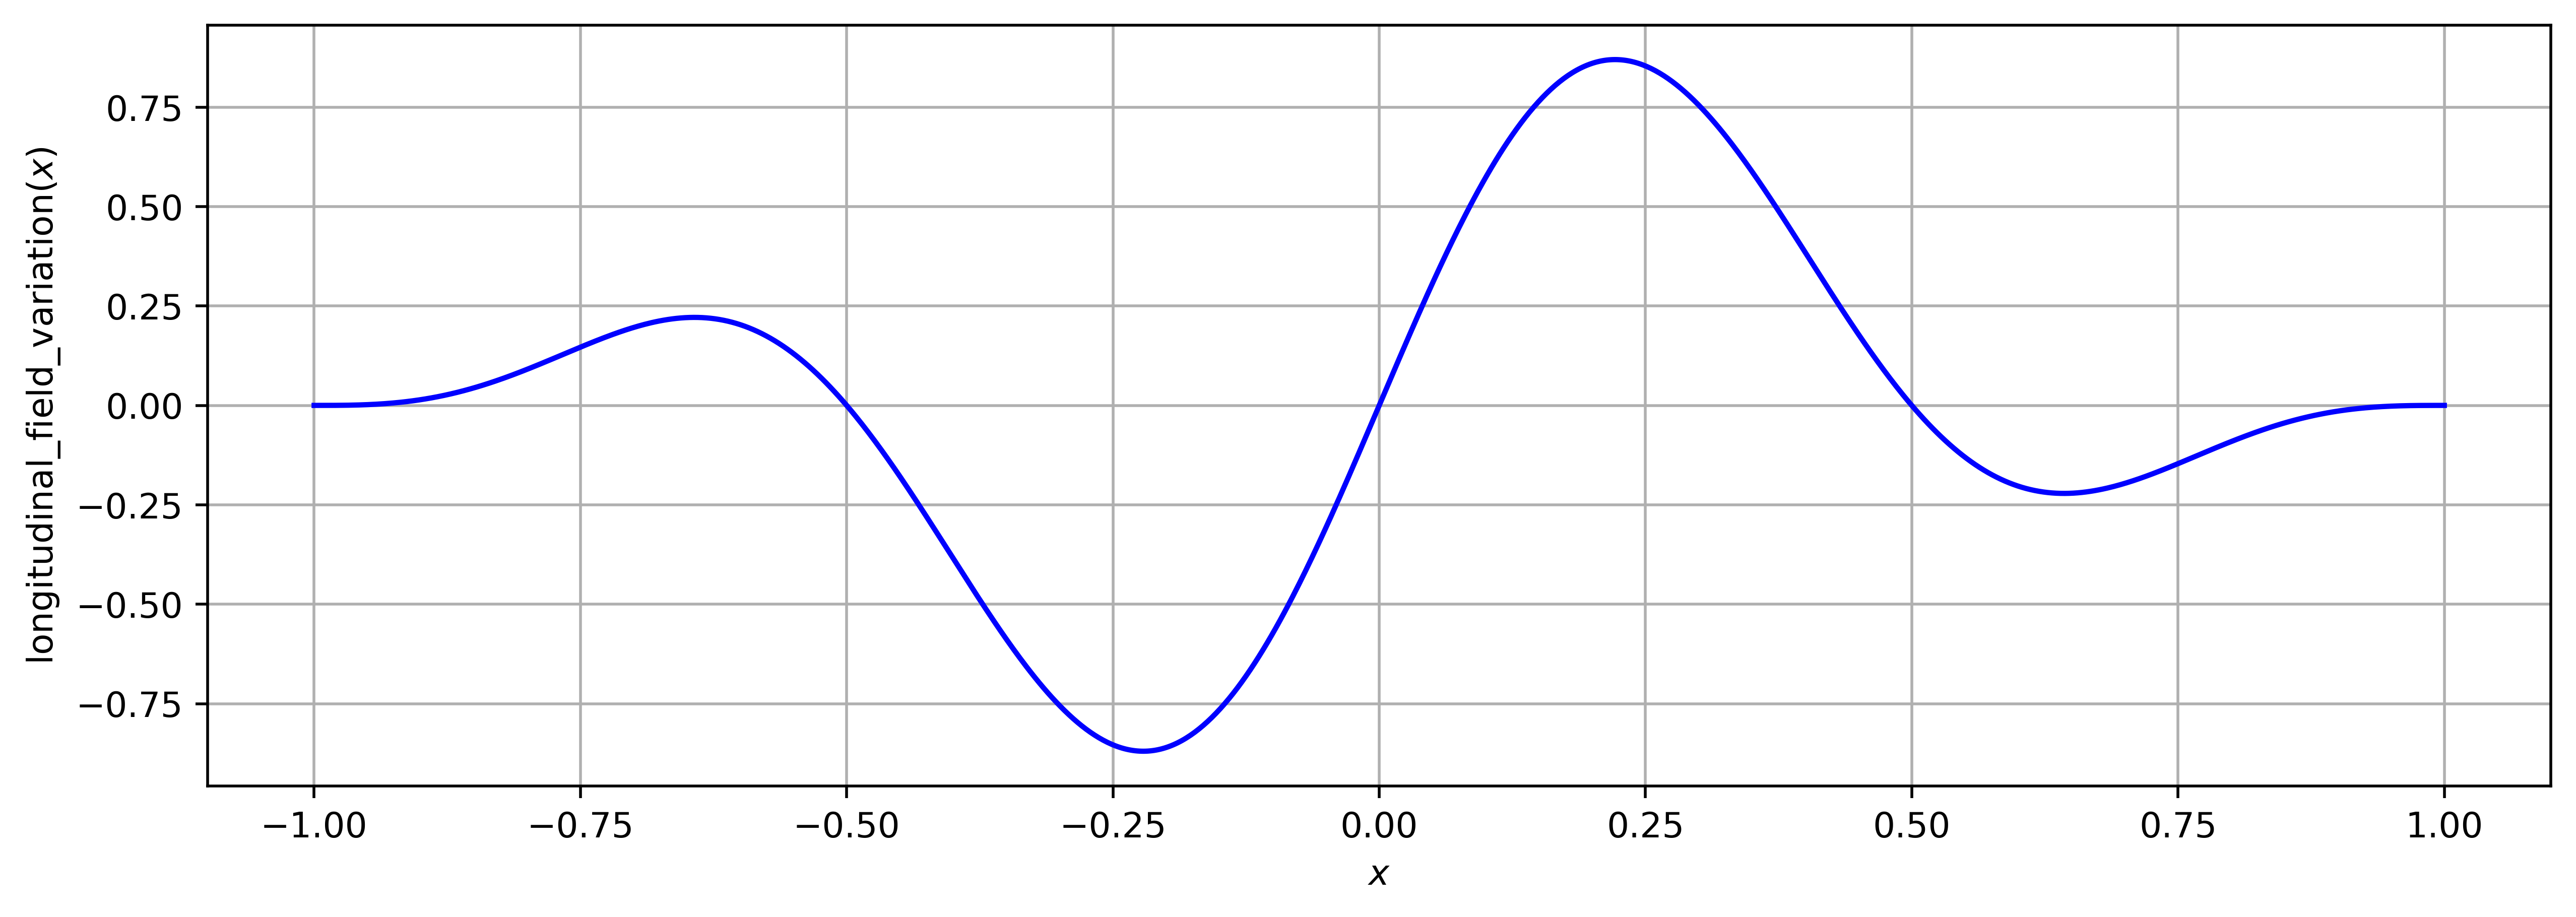

In [15]:
X = np.linspace(-1.0, 1.0, 1000)
Y = np.vectorize(longitudinal_field_variation)(X)
plot_graph(X, Y, "$x$", "longitudinal_field_variation($x$)")

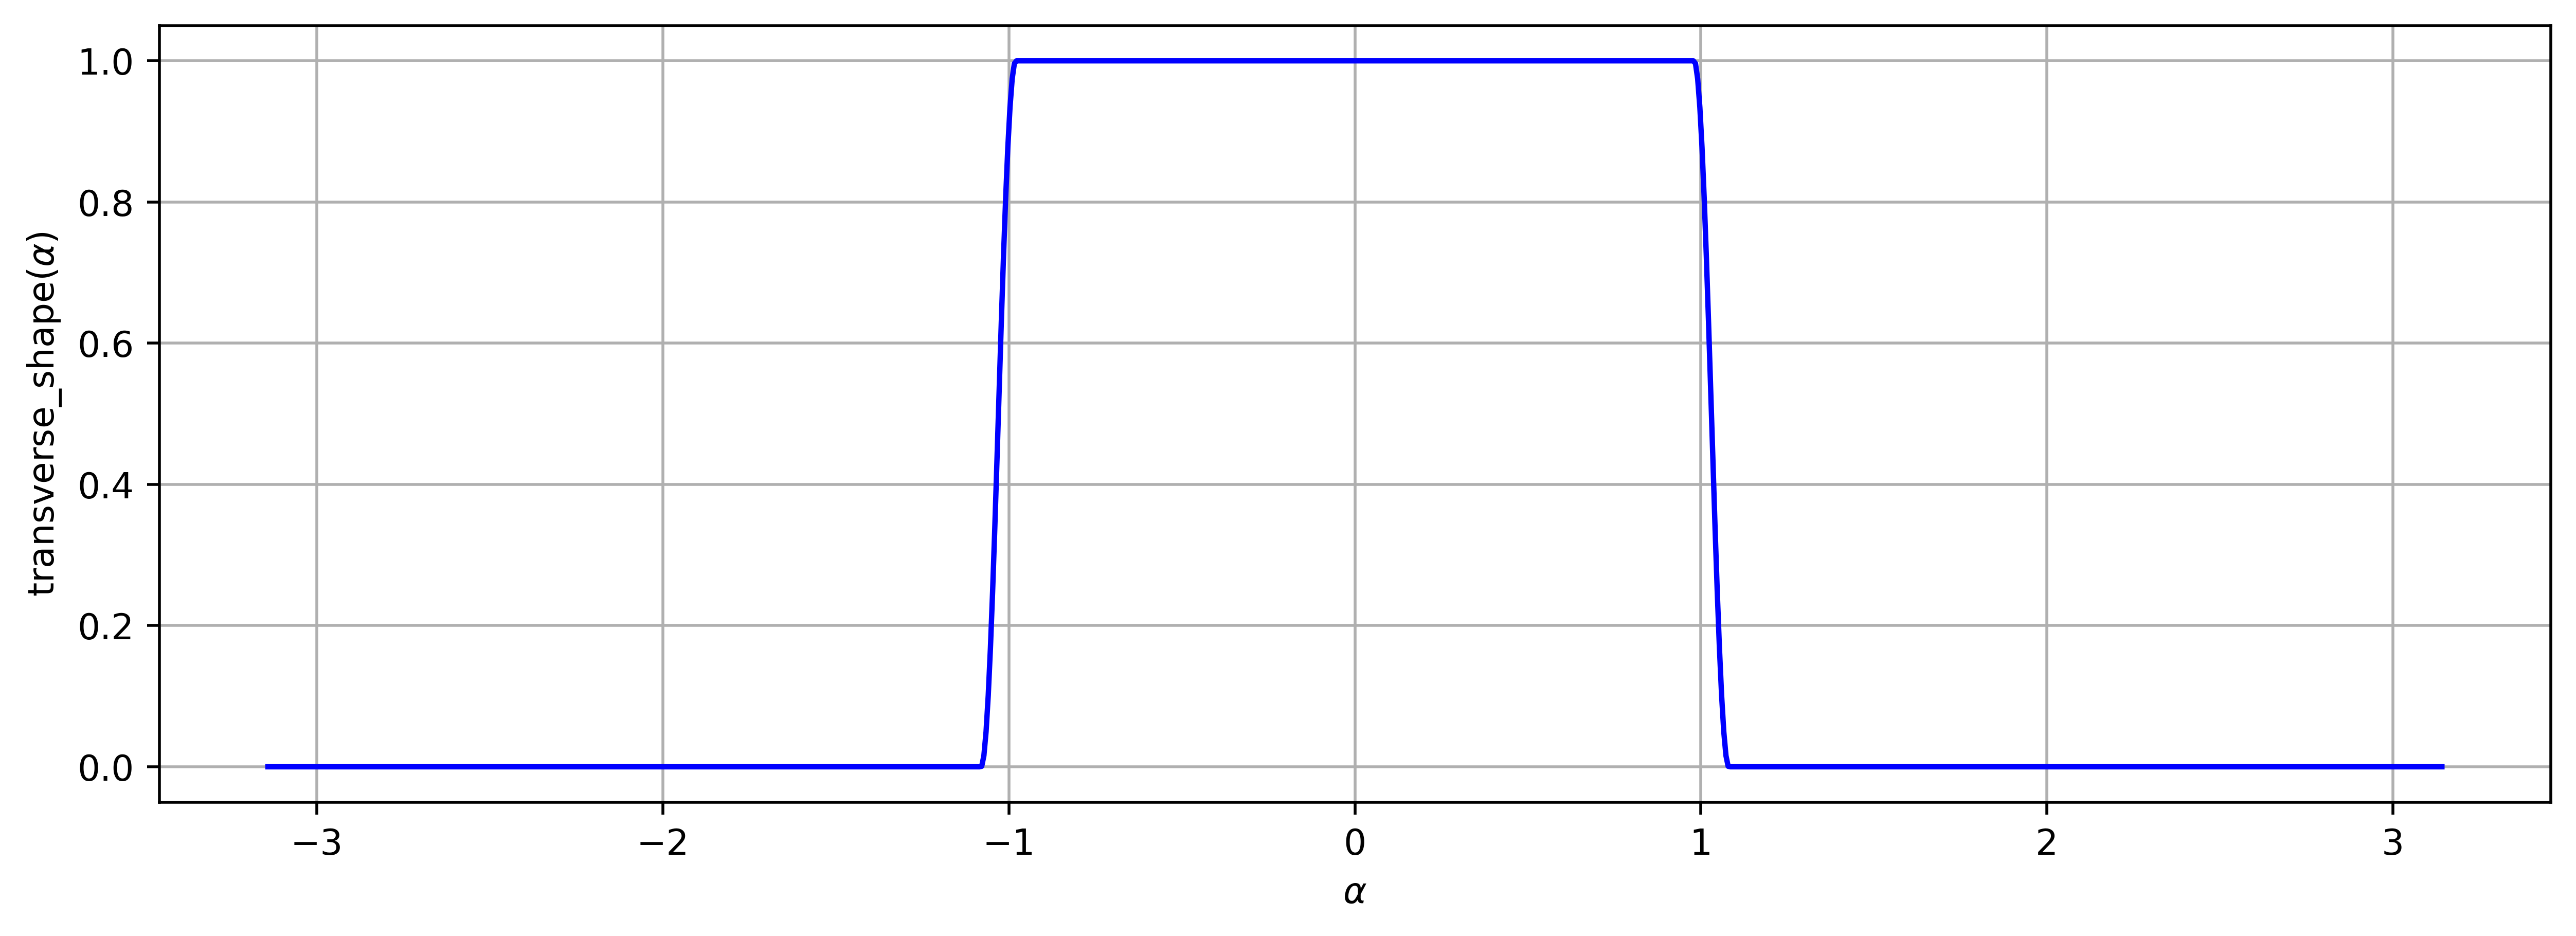

In [16]:
X = np.linspace(-hichi.pi, hichi.pi, 1000)
Y = np.vectorize(transverse_shape)(np.abs(X))
plot_graph(X, Y, "$\\alpha$", "transverse_shape($\\alpha$)")

We can get the field value for a point with coordinates (x, y, z) from the grid. If the point is not a grid node, linear interpolation is performed. The following function reads the field values from the grid and writes them to the numpy array. 

In [17]:
def get_E_norm(field, a=(-20, -20), b=(20, 20), N=(1024, 1024)):
    res = np.zeros(shape=(N[1], N[0]))
    step = ((b[0] - a[0])/N[0], (b[1] - a[1])/N[1])
    for i in range(N[0]):
        for j in range(N[1]):
            # compute the x, y coordinates by index (i, j)
            x = a[0] + i*step[0]
            y = a[1] + j*step[1]
            coord = hichi.Vector3d(x, y, 0.0)  # z=0
            # get the norm of electric field at the point (x, y, z)
            res[N[1]-j-1, i] = field.get_E(coord).norm()            
    return res

You can use a color map to show the resulting field values.

In [18]:
def plot_im(values, vmin=0.0, vmax=1e-2, a=(-20, -20), b=(20, 20)):
    fig = plt.figure(dpi=500, figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.tick_params(axis='both', which='major')
    im = ax.imshow(values, cmap='RdBu', interpolation='none',
                   extent=(a[0], b[0], a[1], b[1]), vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    plt.show()

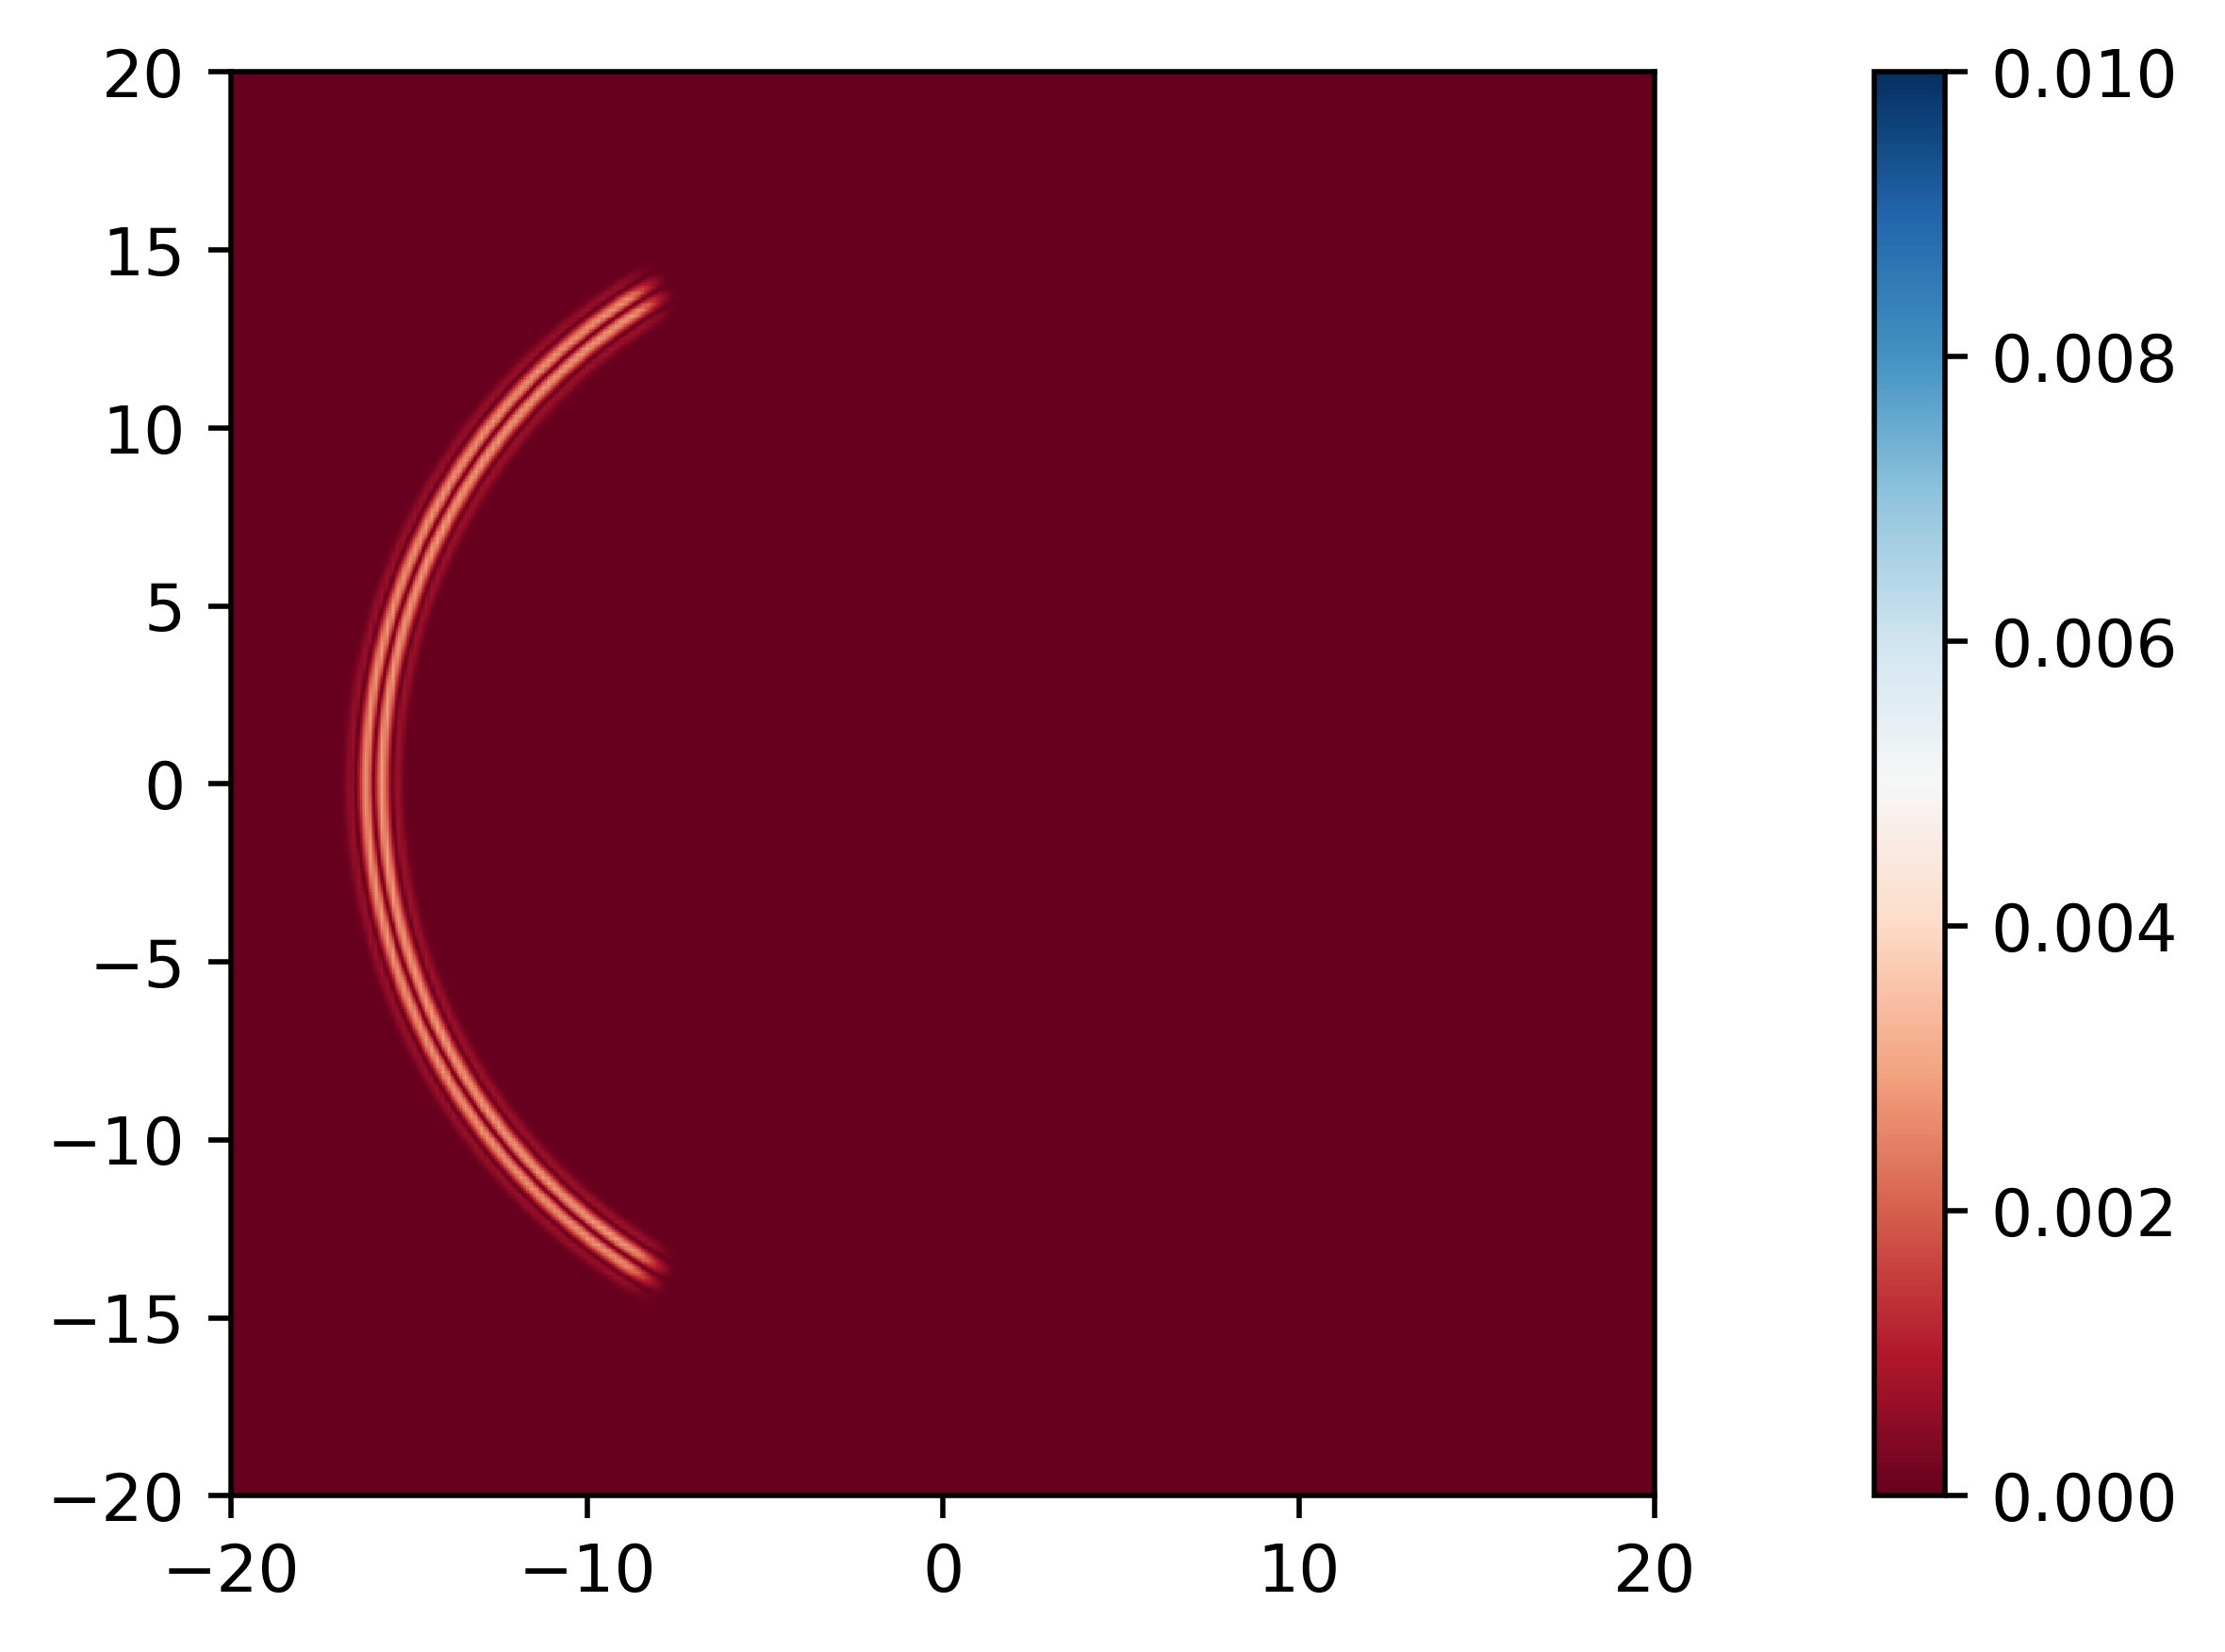

In [19]:
plot_im(get_E_norm(field))

## Start field solver

The next step is to run the field solver. To update field values by the time step given earlier, just call the *update_fields()* method.

In [20]:
start_time = time.process_time()

field.update_fields()

field_solver_time = time.process_time() - start_time
print("Time is %0.2f s" % (field_solver_time))

Time is 14.34 s


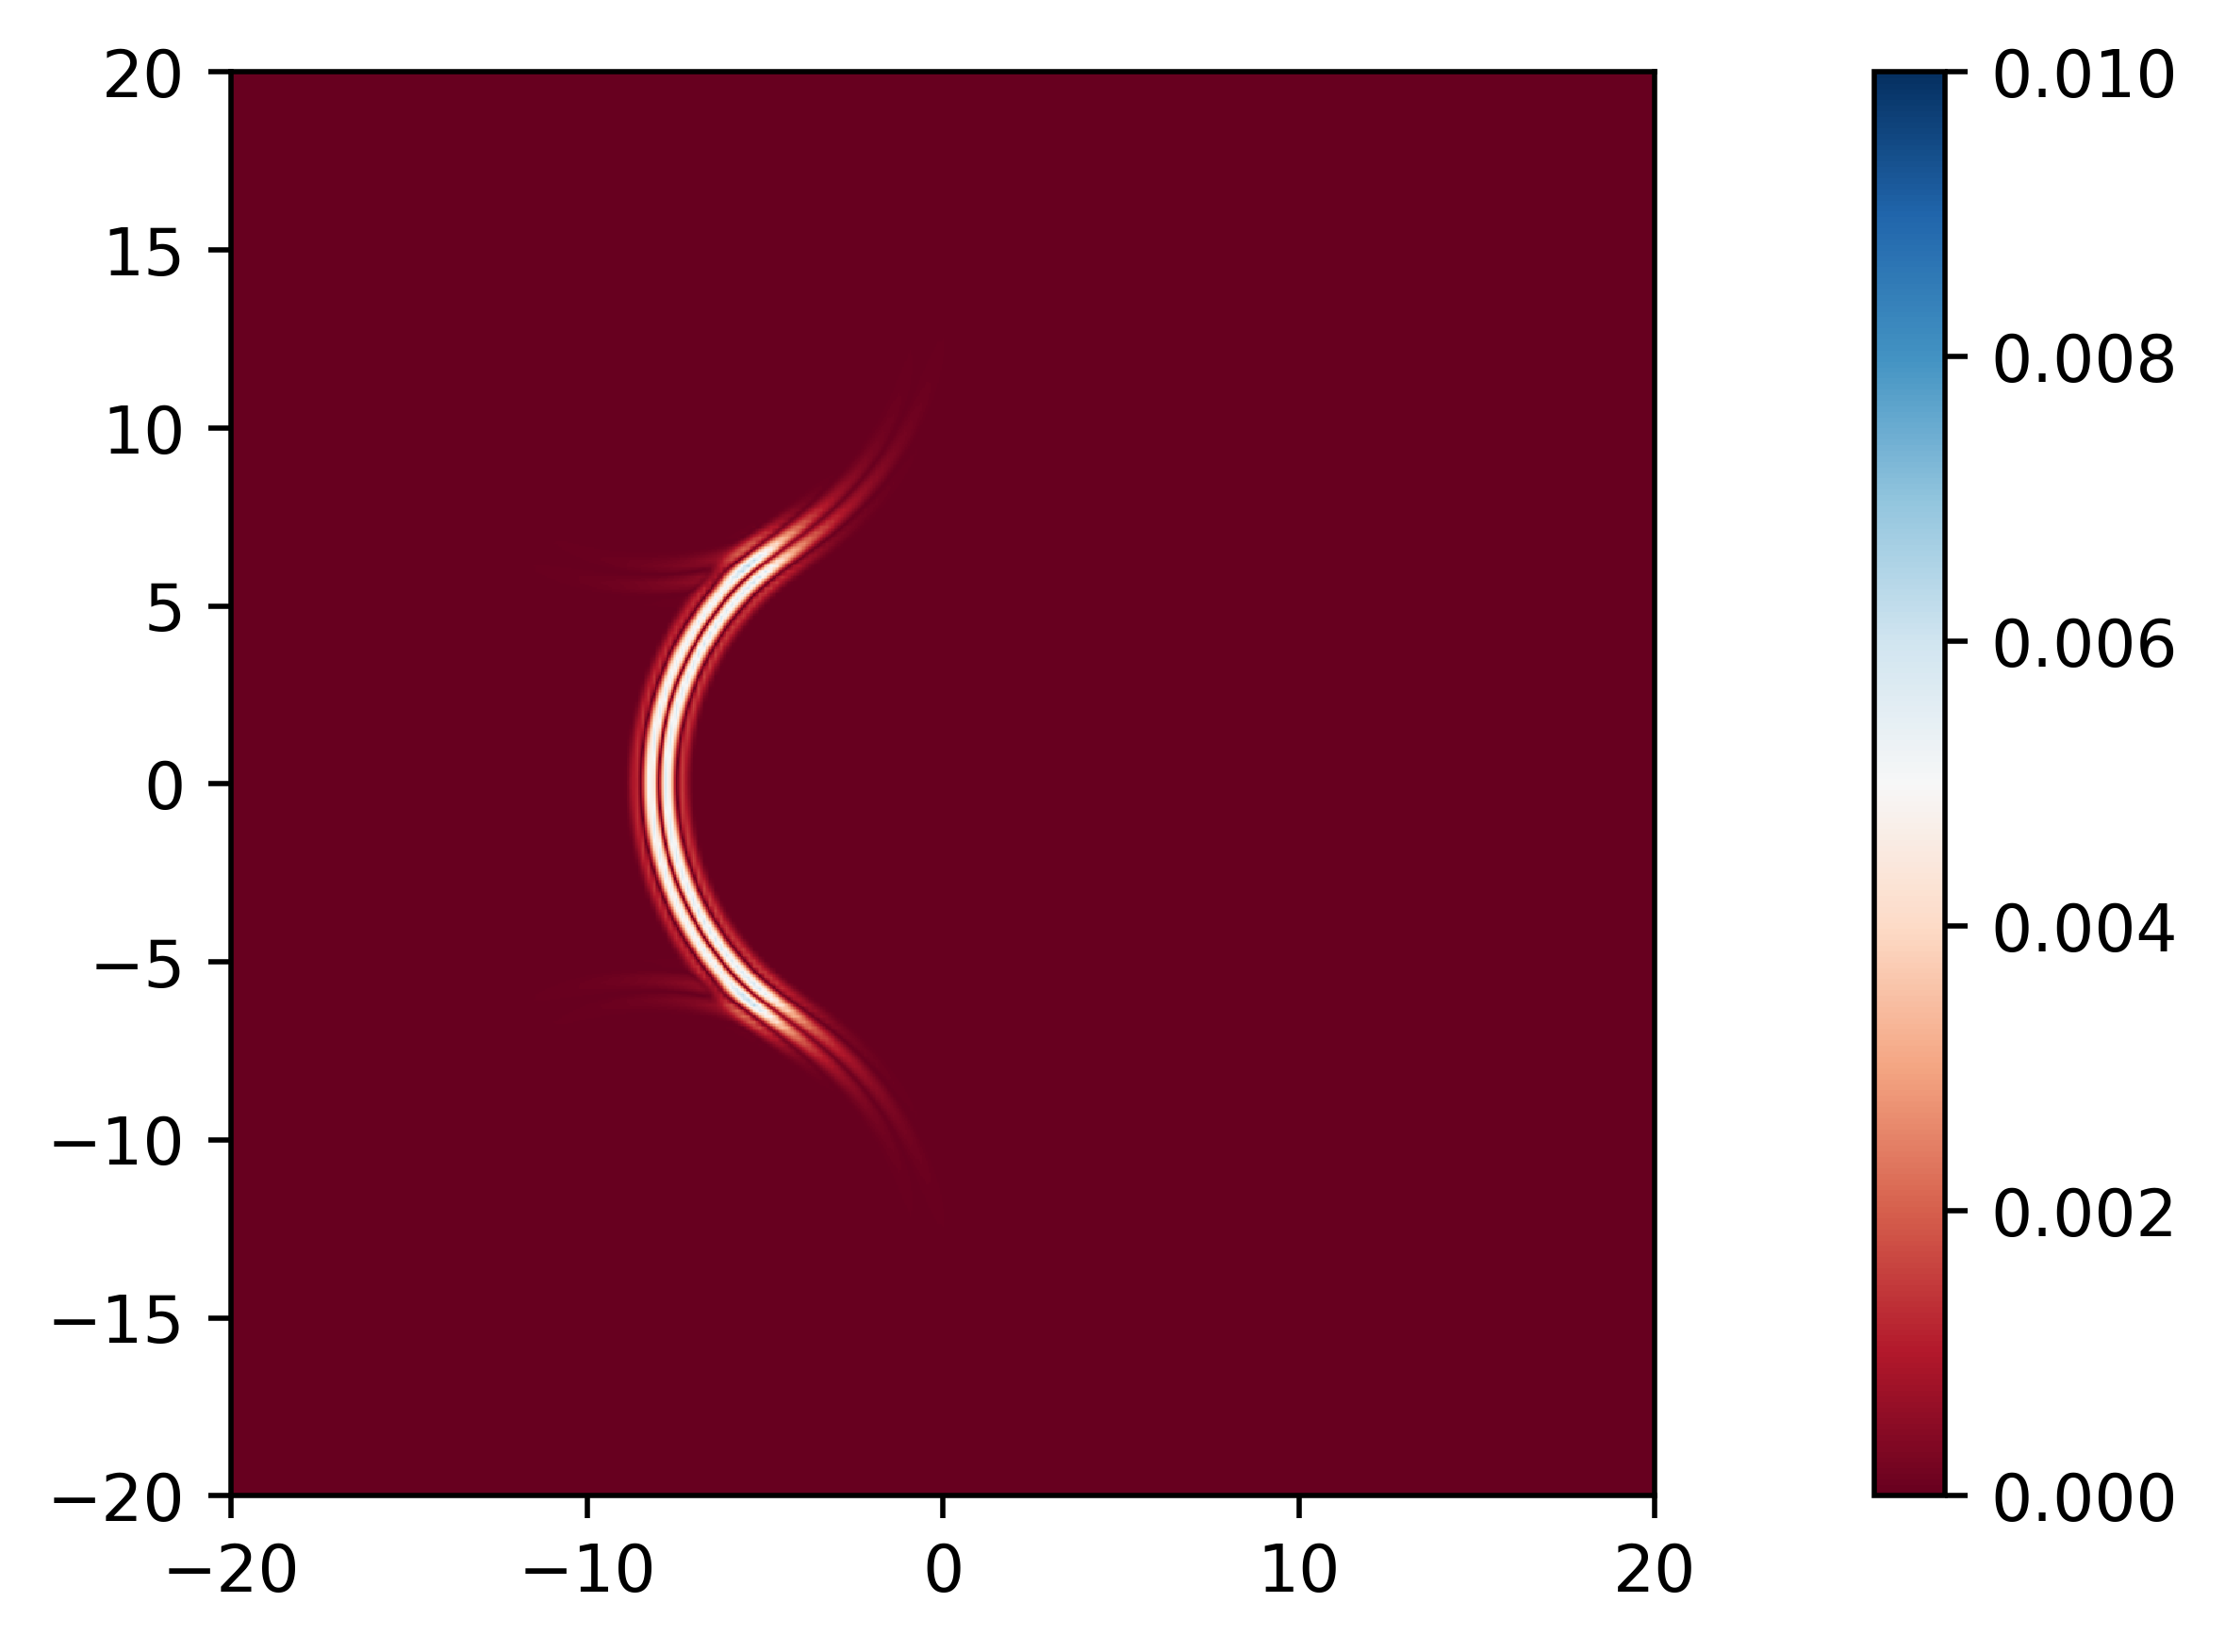

In [21]:
plot_im(get_E_norm(field))

The large opening angle allows us to assume that the peak intensity is reached at time $R_0/c$ from the beginning of the calculation. The following code computes the peak value of the field.

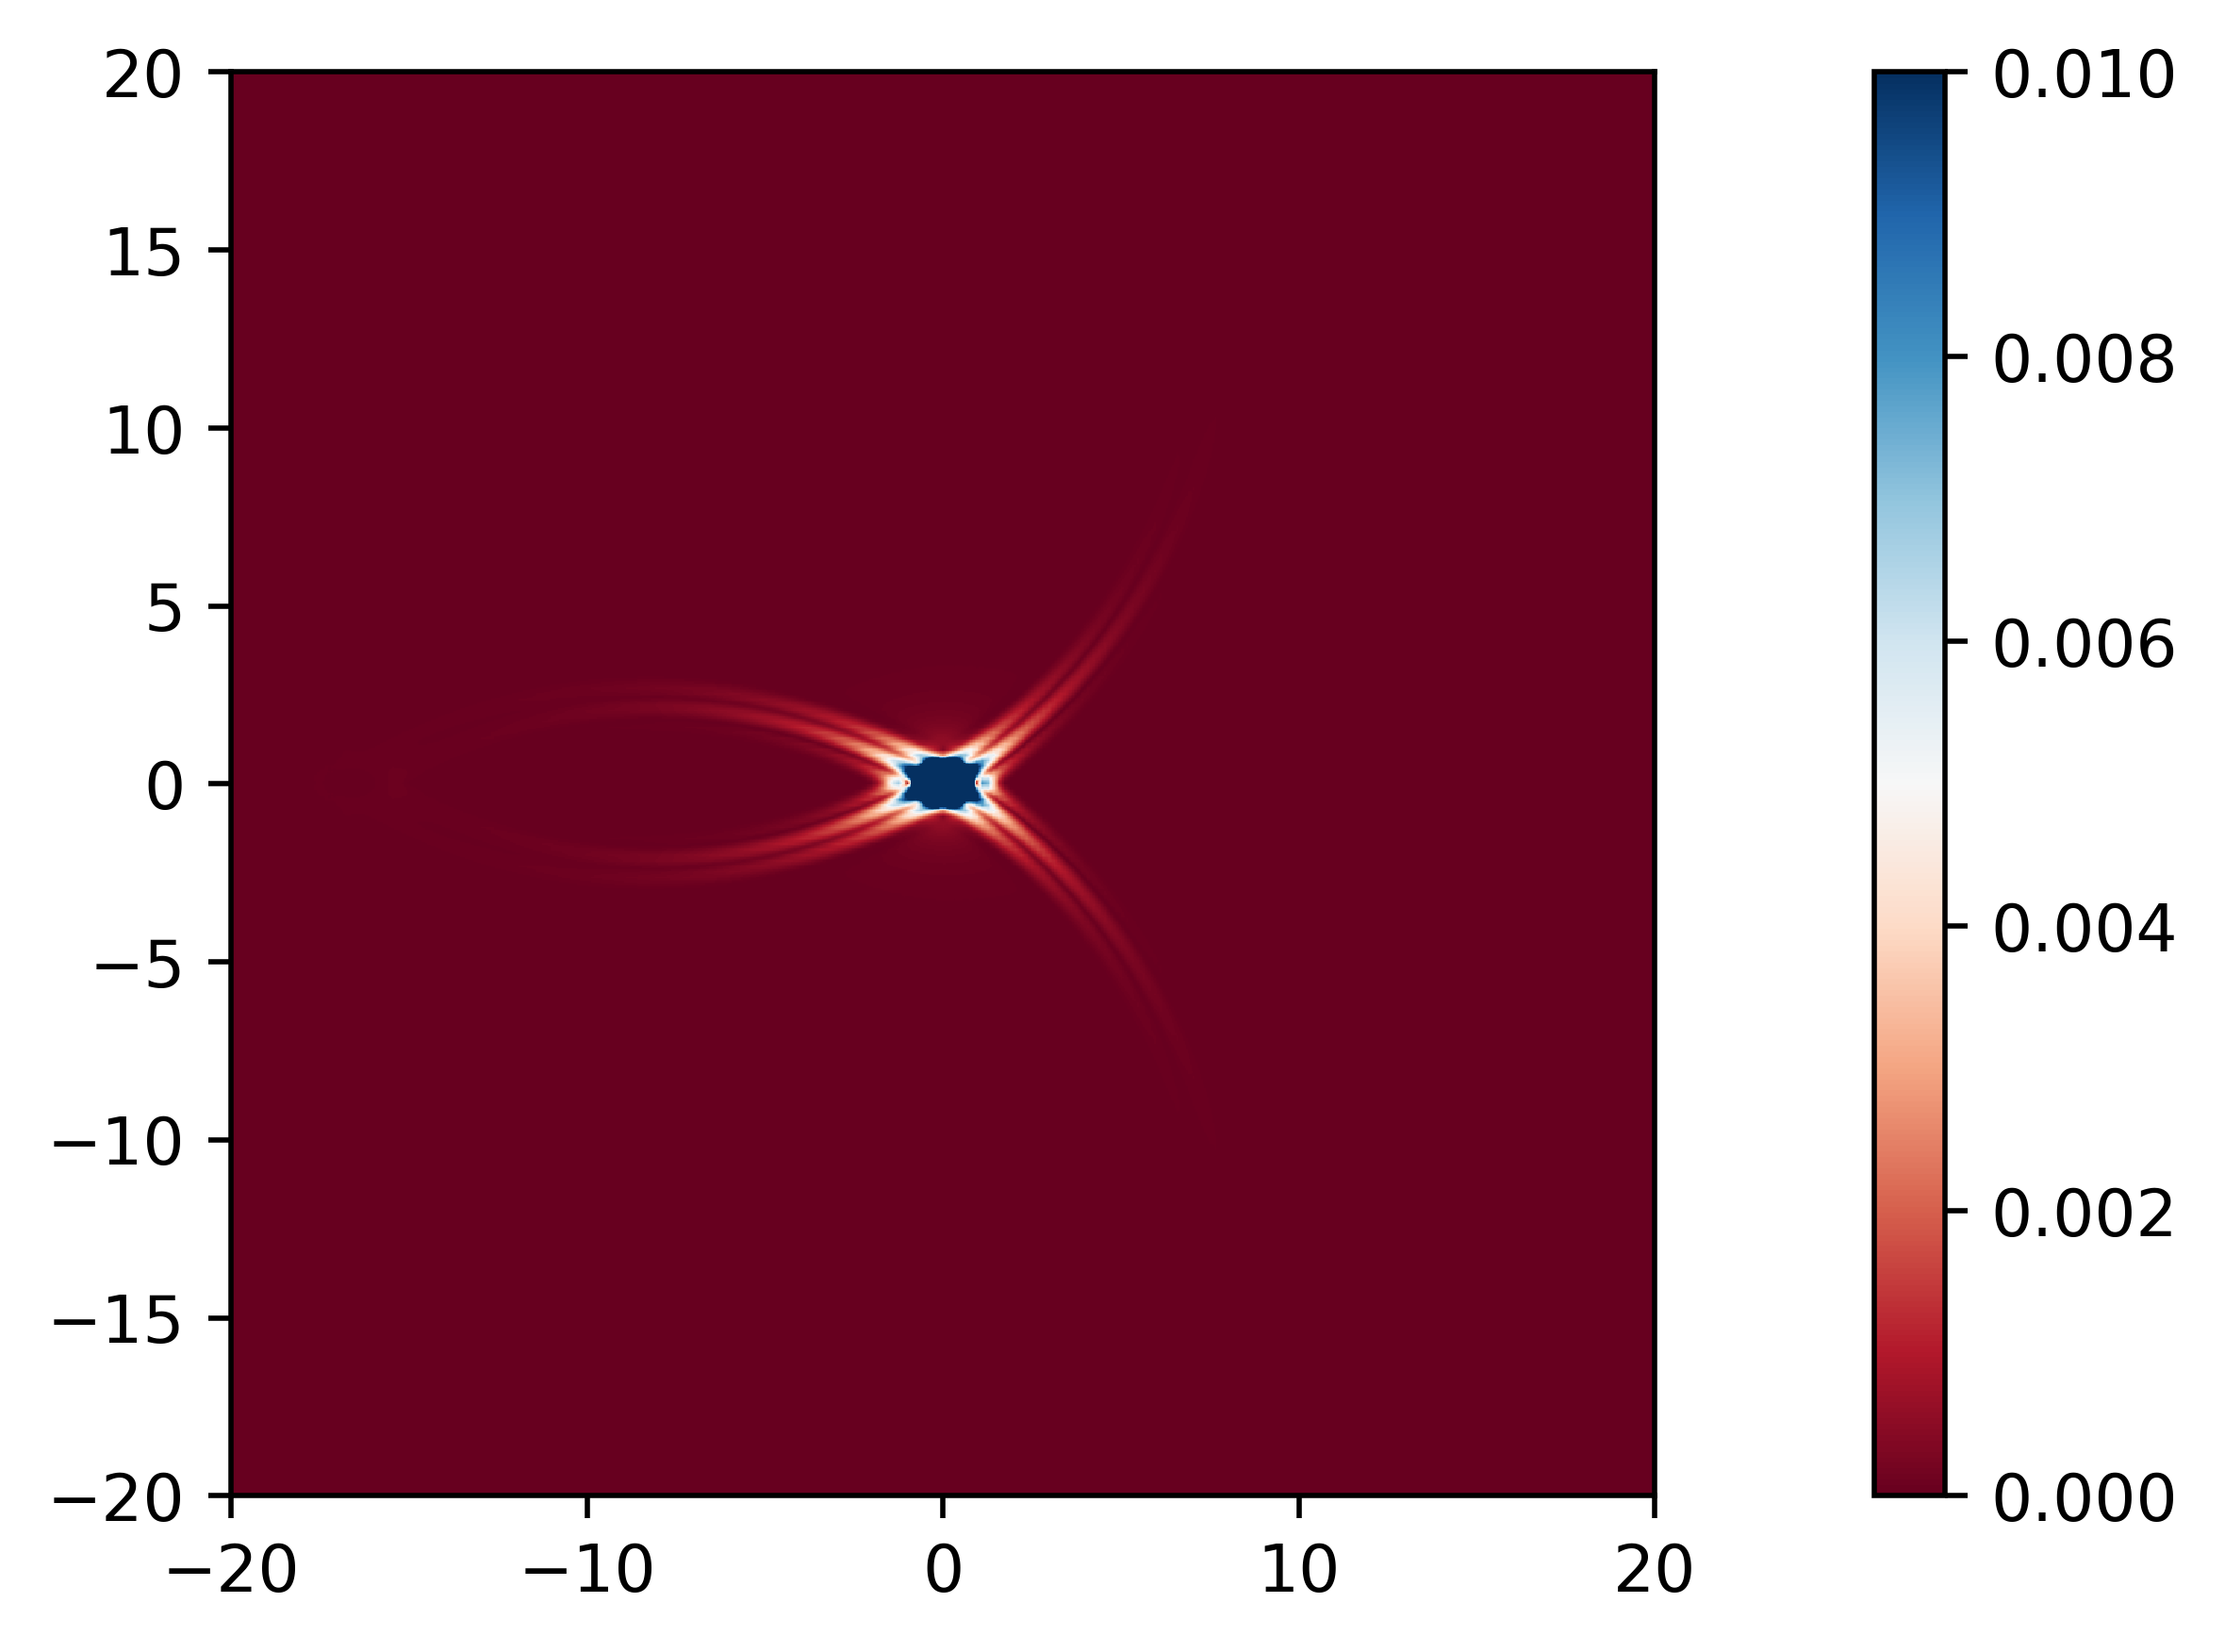

Peak field value is 0.141458


In [22]:
field.update_fields()
field_arr = get_E_norm(field)
plot_im(field_arr)
peak_field = field_arr.max()
print("Peak field value is %f" % (peak_field))

## Tight Focusing Mapping

Based on the geometric properties of the tight focusing problem, only a small fraction of the computational grid accommodates the pulse. The main idea is to reduce computational costs due to areas with zero field values. We propose to get rid of additional computational costs by introducing a periodic structure of the field and, as a consequence, reducing the initial region to a thin layer along the x-axis. Let's set the width of the band $D$ along the x-axis.

In [23]:
D = 3.75*pulselength
print(D)

7.5


Redusing the computational grid size by $(20 - (-20))/7.5=5.33$ times along the x-axis makes possible to reduce the memory costs and to speed up simulation by 5-6 times.

In [24]:
new_grid_size_X = int(grid_size.x*D/(max_coords.x - min_coords.x))
print(new_grid_size_X)

48


The next step is to create the appropriate mapping and to apply this to the field instance. Band boundaries (x_min, x_max) are determined automatically by the mapping.

In [25]:
mapping = hichi.TightFocusingMapping(R0, pulselength, D, hichi.Axis.X)

In [26]:
x_min = mapping.get_min_coord()
x_max = mapping.get_max_coord()
print(x_min, x_max)

-22.5 -15.0


In [27]:
band_min_coords = hichi.Vector3d(x_min, -20, -20)
band_max_coords = hichi.Vector3d(x_max, 20, 20)
band_grid_size = hichi.Vector3d(new_grid_size_X, grid_size.y, grid_size.z)

In [28]:
field = hichi.PSATDPoissonField(band_grid_size, band_min_coords,
                                grid_step, time_step)
field = field.apply_mapping(mapping)

In [29]:
_ = initialize_field(field)

To illustrate how the mapping works, let's disable the inverse transform. To do this, we need to modify the mapping instance accordingly by calling the *if_perform_inverse_mapping()* method.

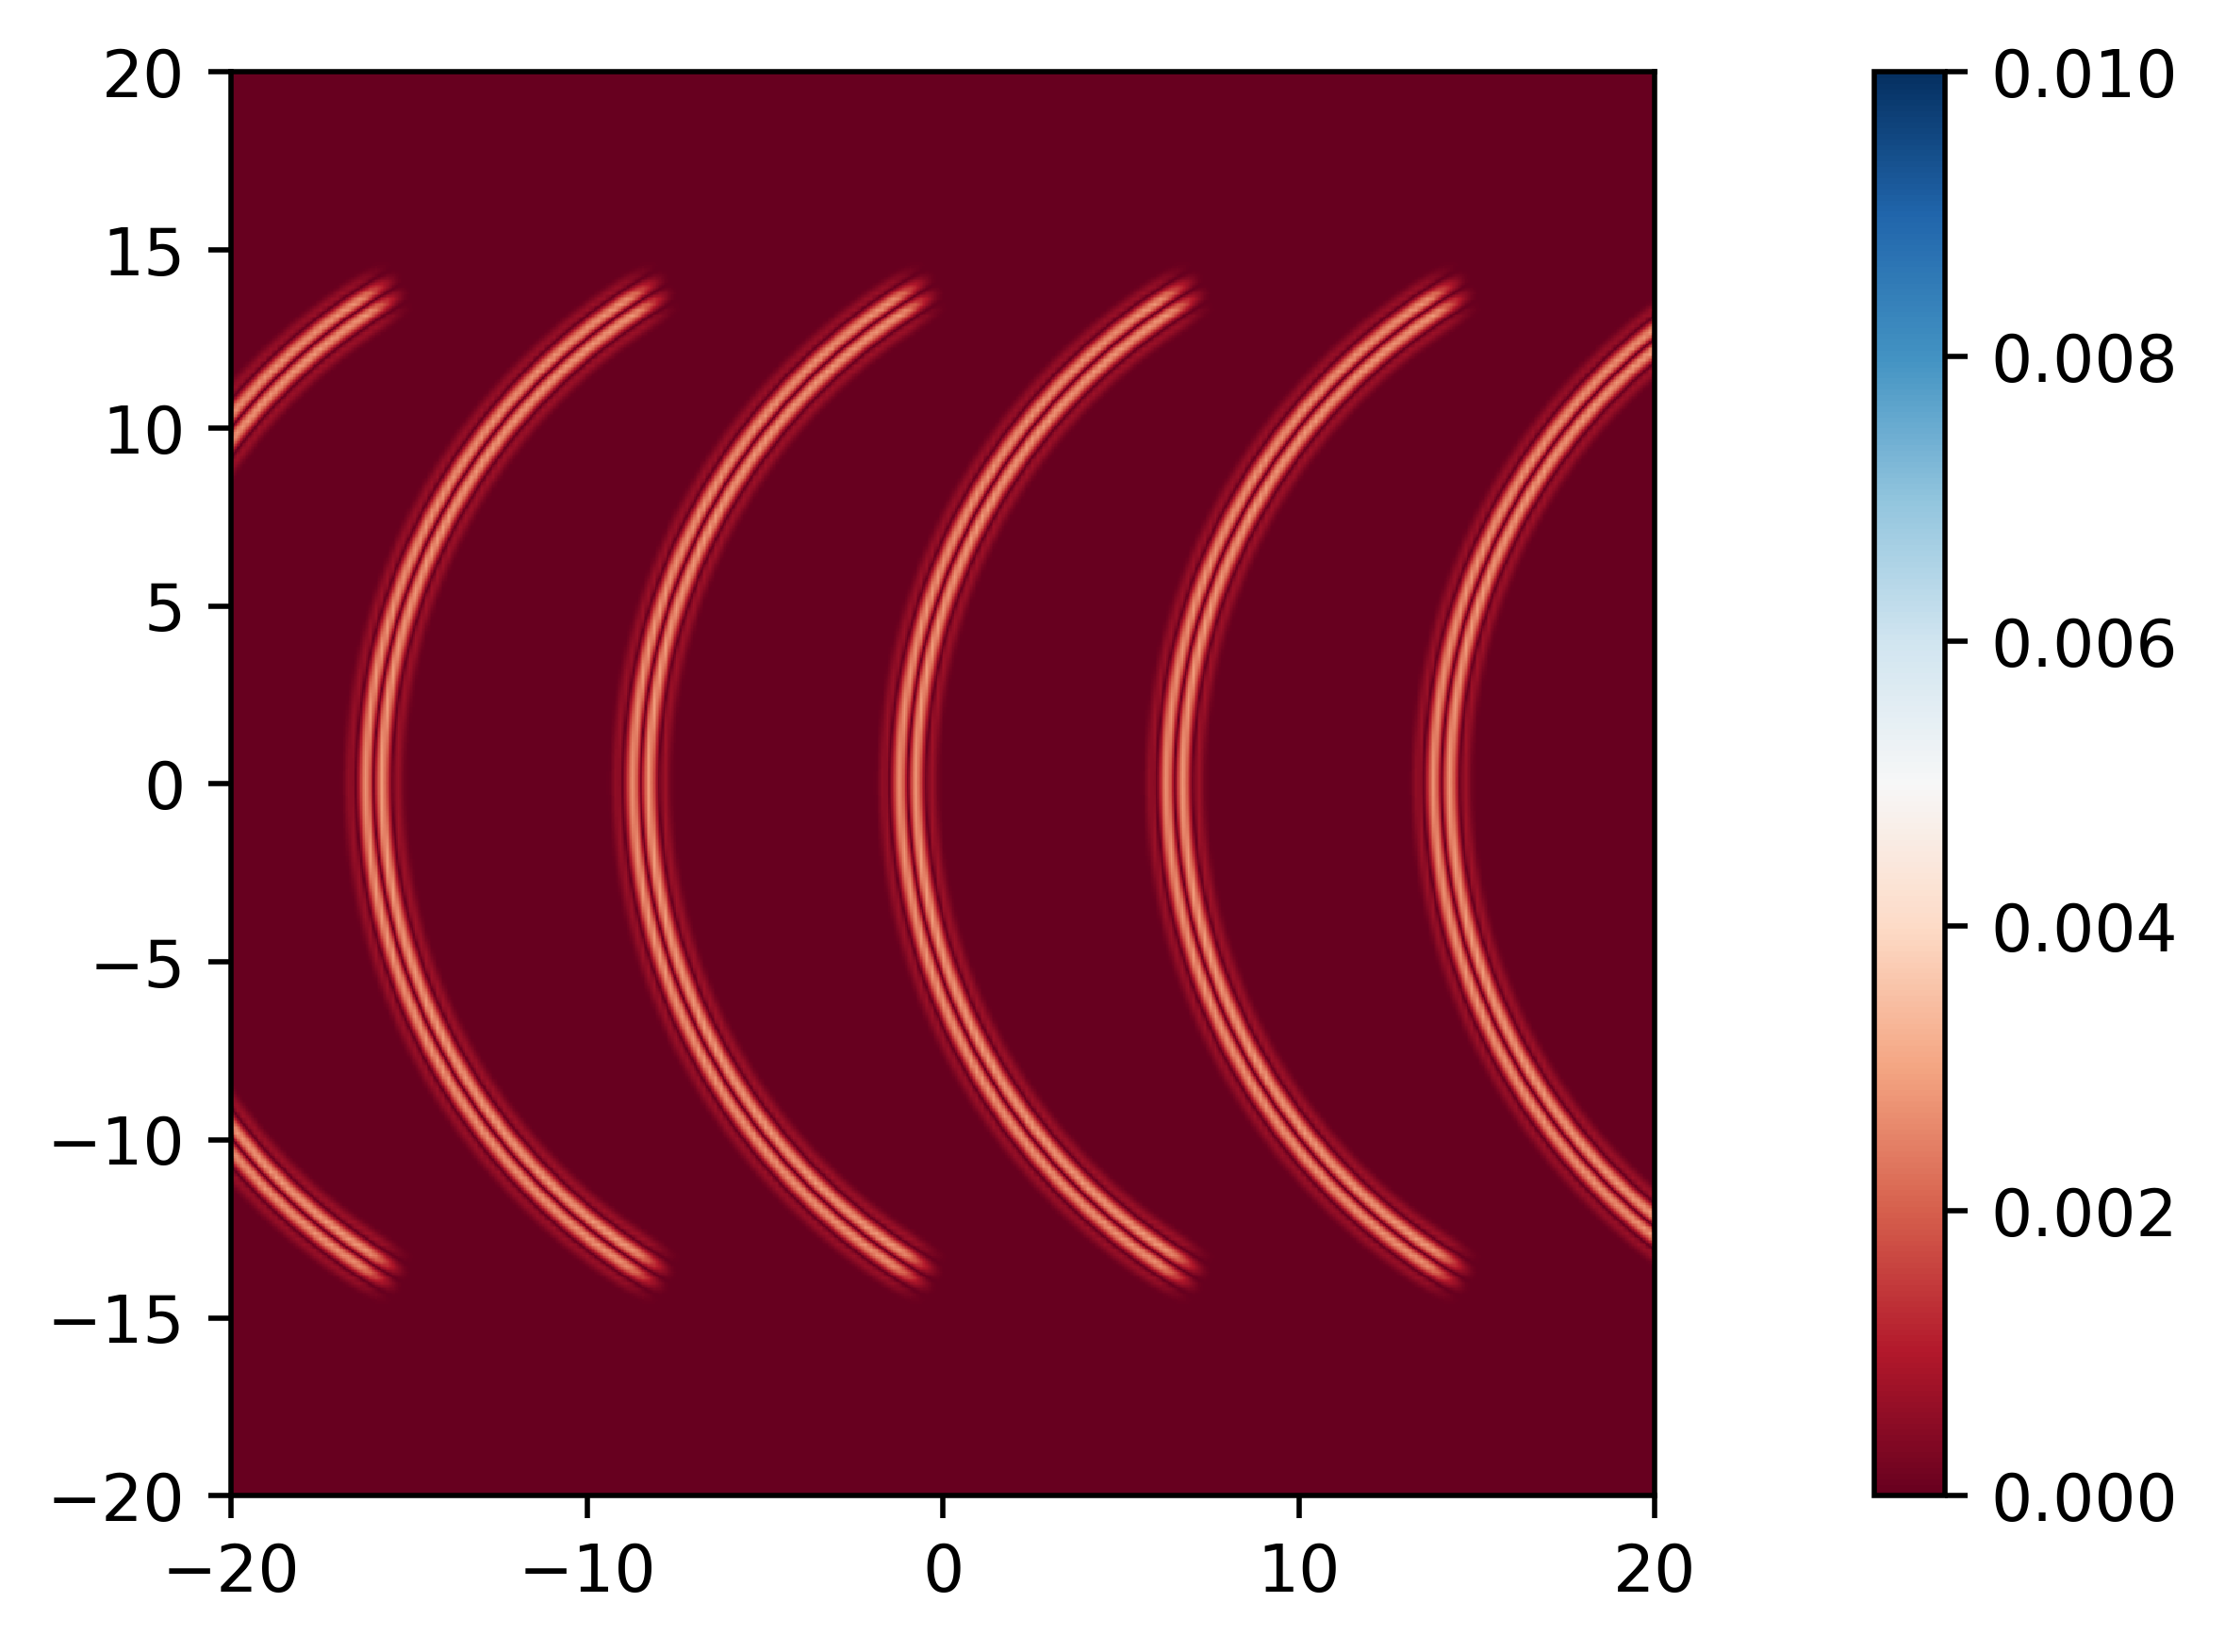

In [30]:
mapping.if_perform_inverse_mapping(False)
plot_im(get_E_norm(field))

We can see that the initial pulse was duplicated along the x-axis, as a result of which the space became periodic. This allows the simulation to be performed out only in the band shown below.

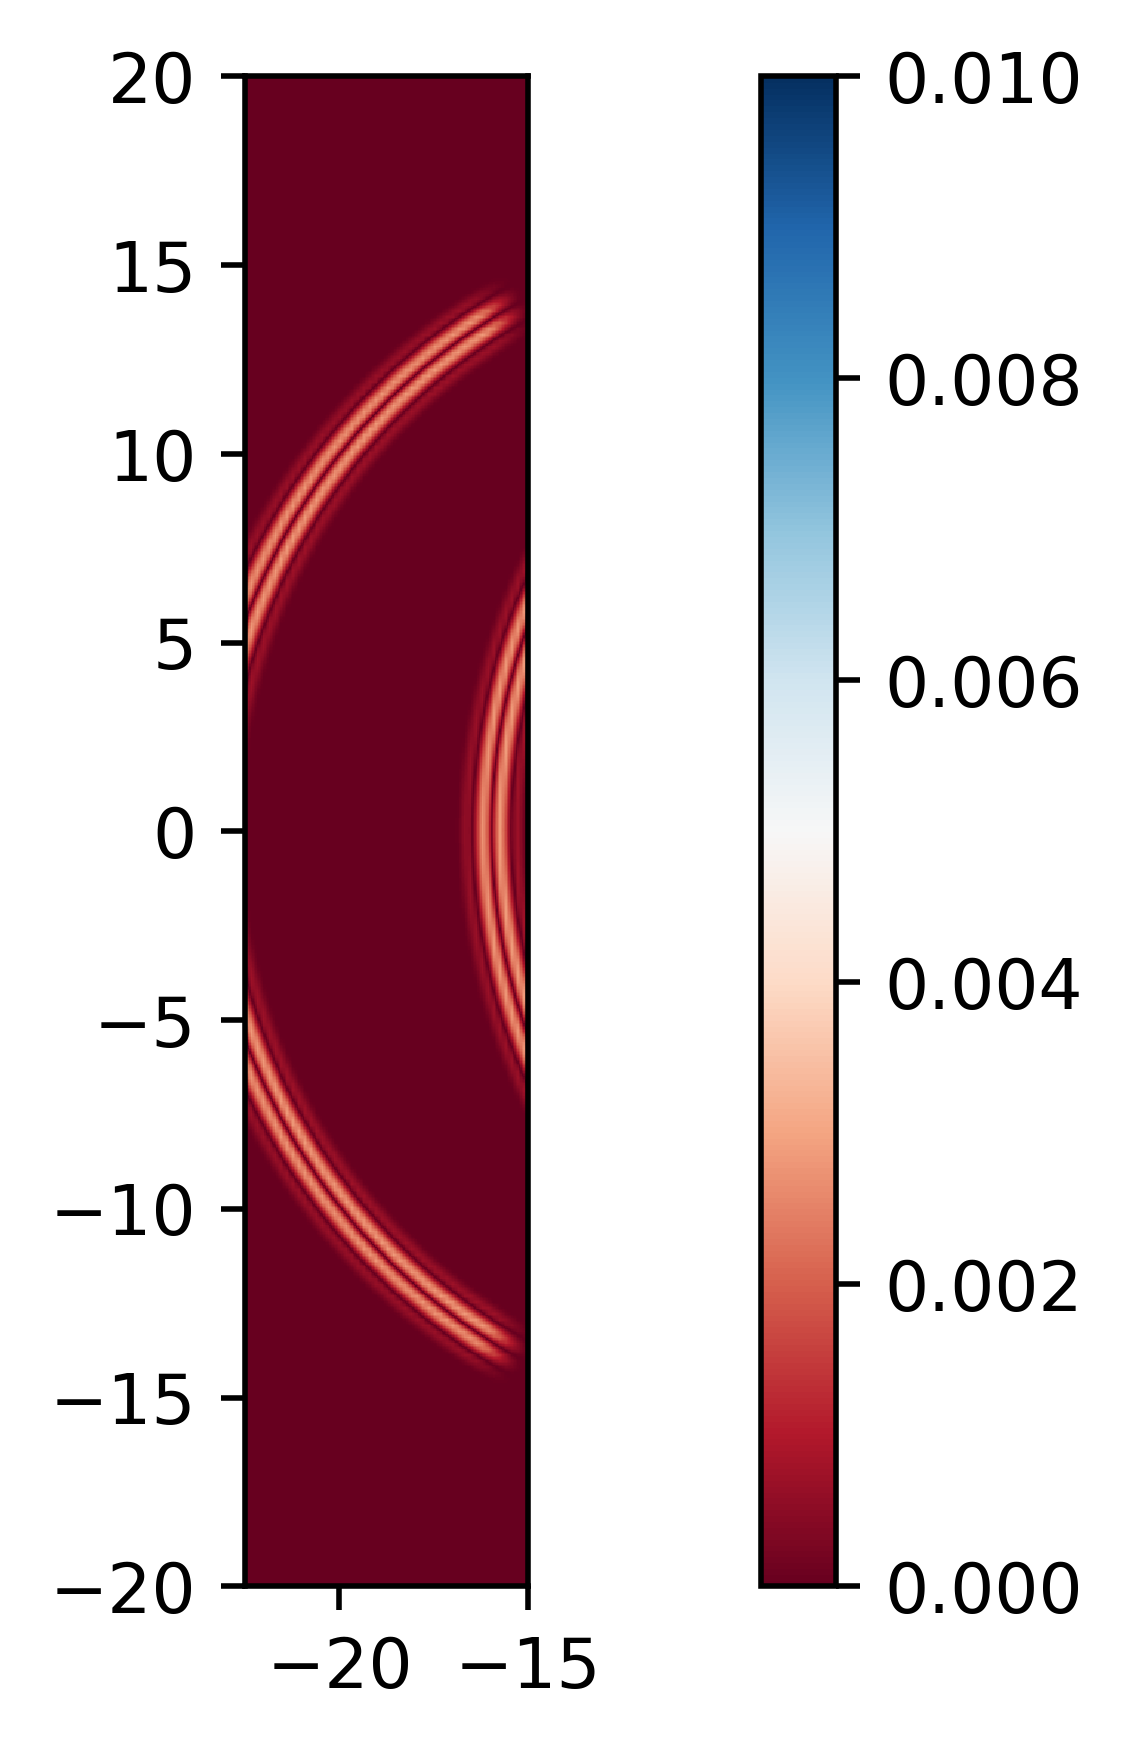

In [31]:
band = ((x_min, min_coords.y), (x_max, max_coords.y))
plot_im(get_E_norm(field, a=band[0], b=band[1], N=(192, 1024)),
        a=band[0], b=band[1])

We can see that the field solver time decreases as expected.

In [32]:
start_time = time.process_time()

field.update_fields()

field_solver_time_band = time.process_time() - start_time
print("Time is %0.2f s" % (field_solver_time_band))
print("Computational costs are decreased by %0.2f times" % \
           (field_solver_time/field_solver_time_band))

Time is 2.88 s
Computational costs are decreased by 4.99 times


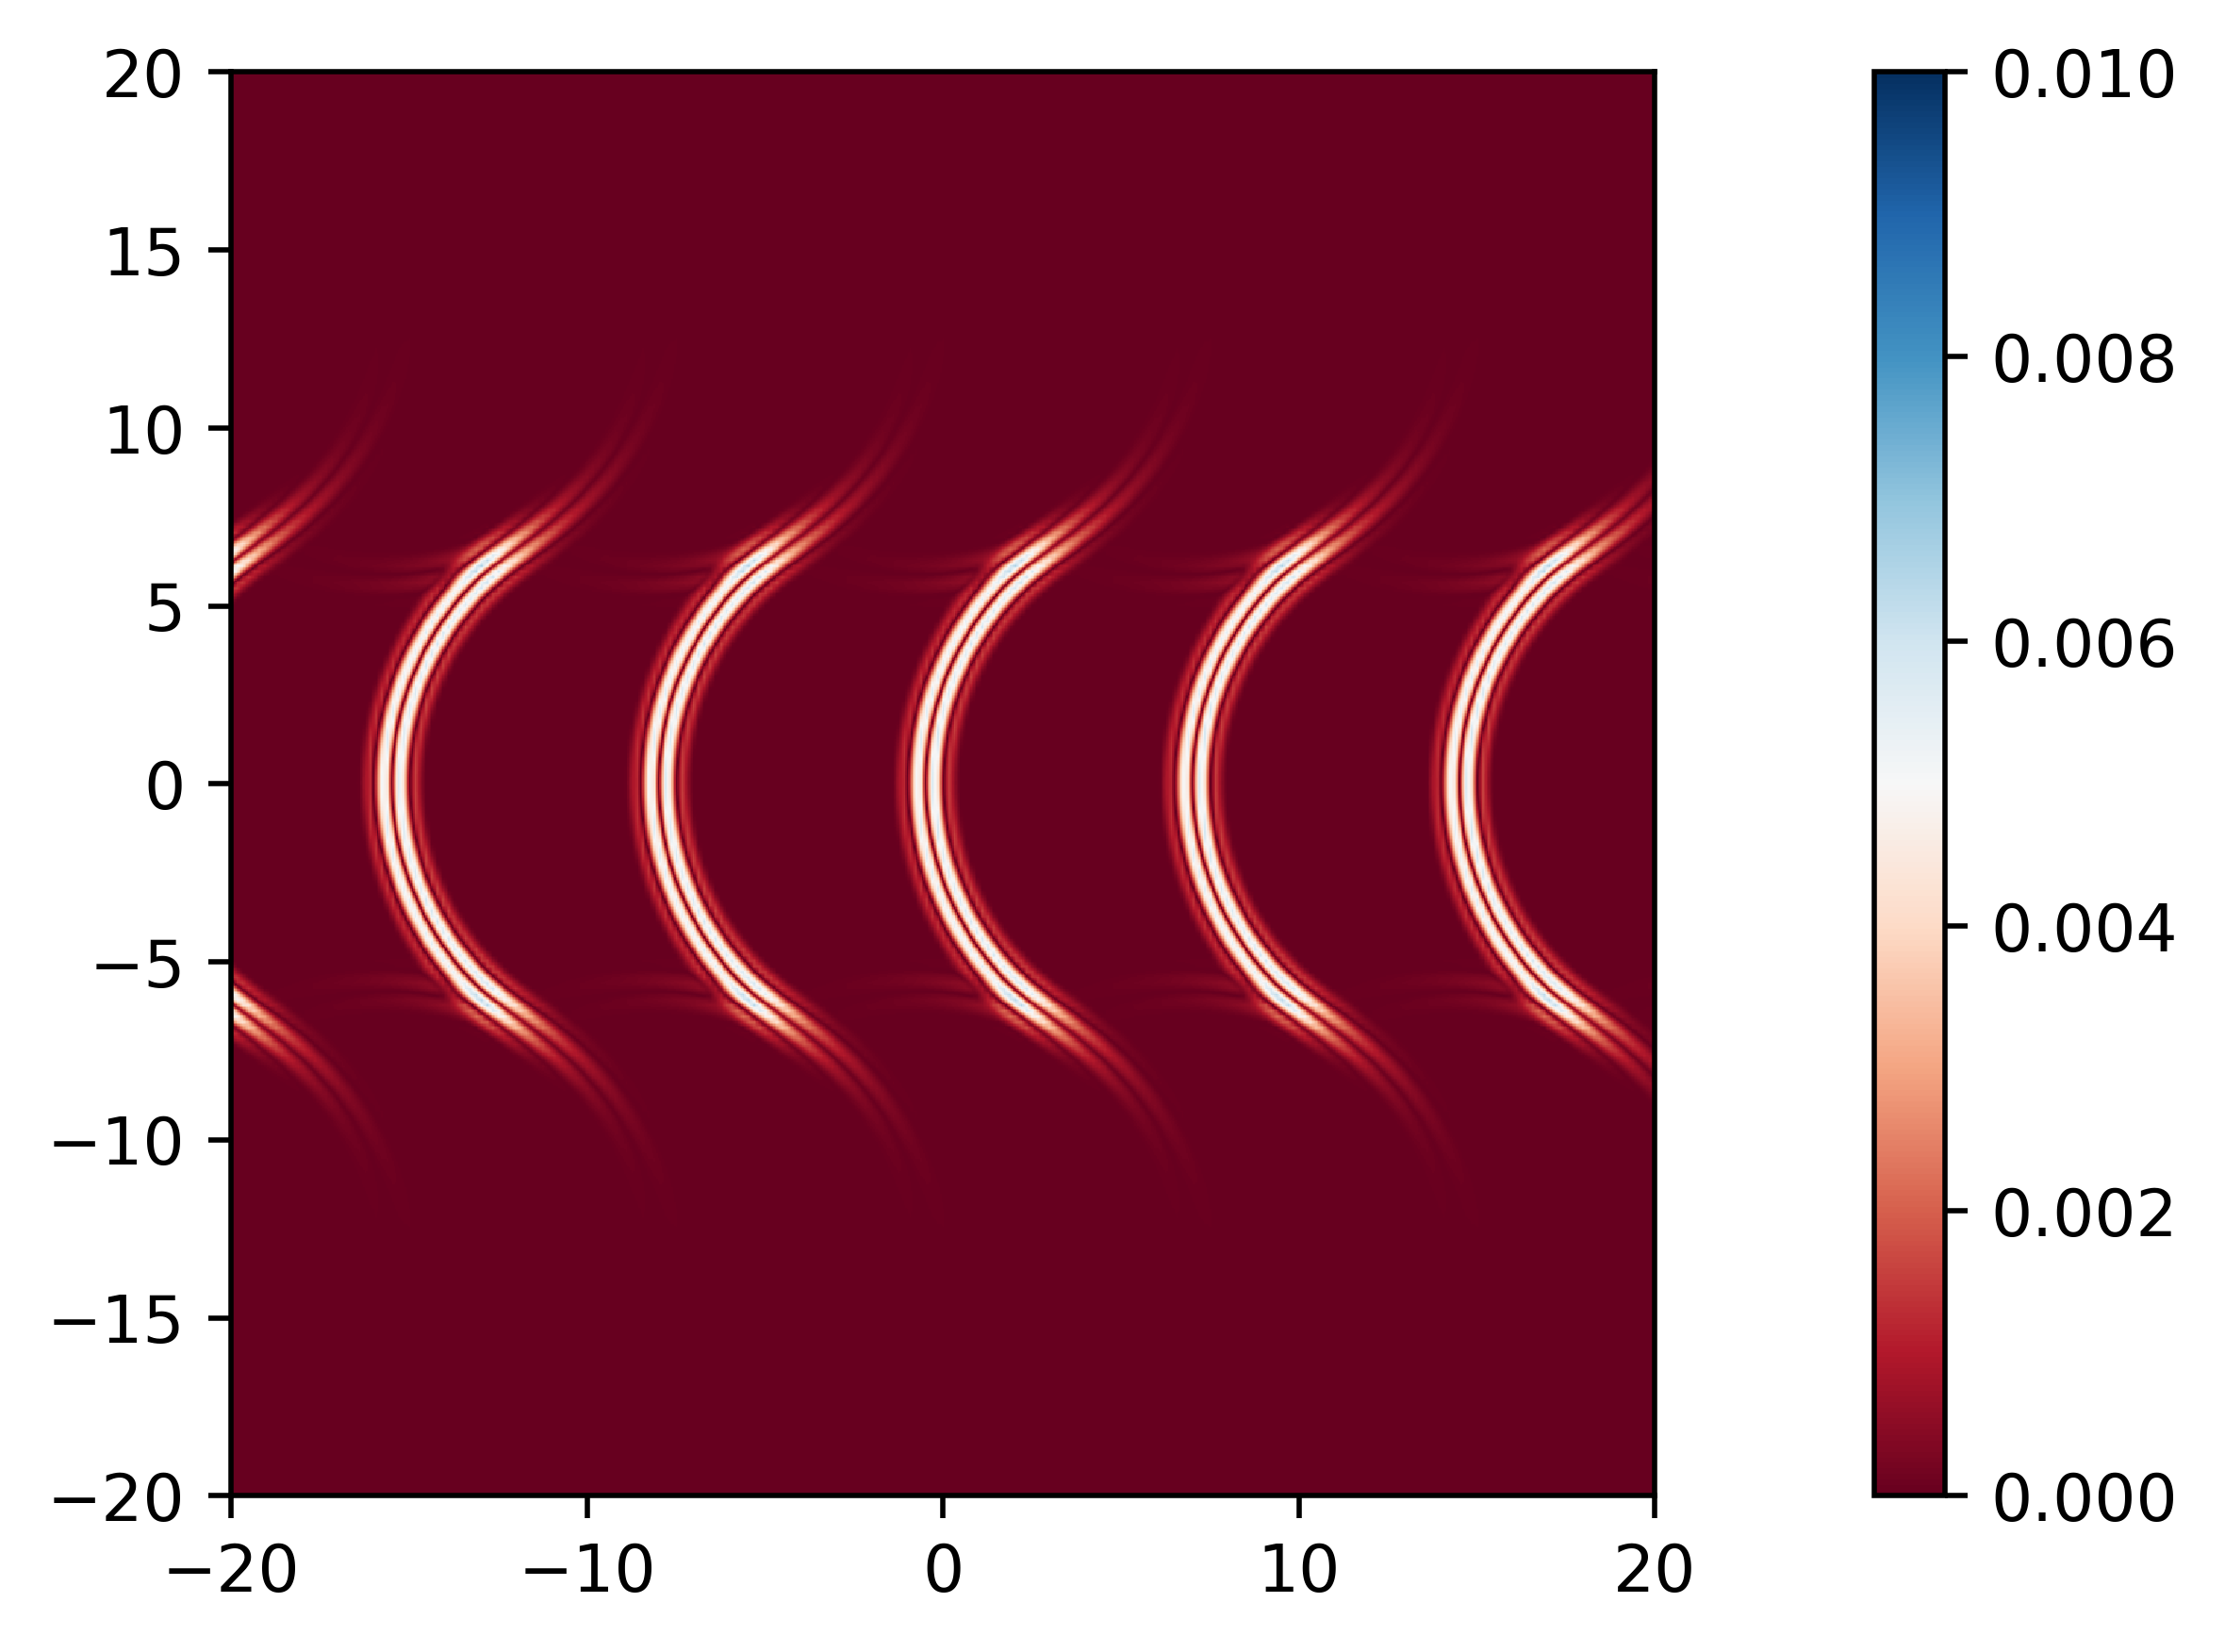

In [33]:
plot_im(get_E_norm(field))

Let's turn on the inverse mapping again, which 'cuts' the original pulse from the periodic space.

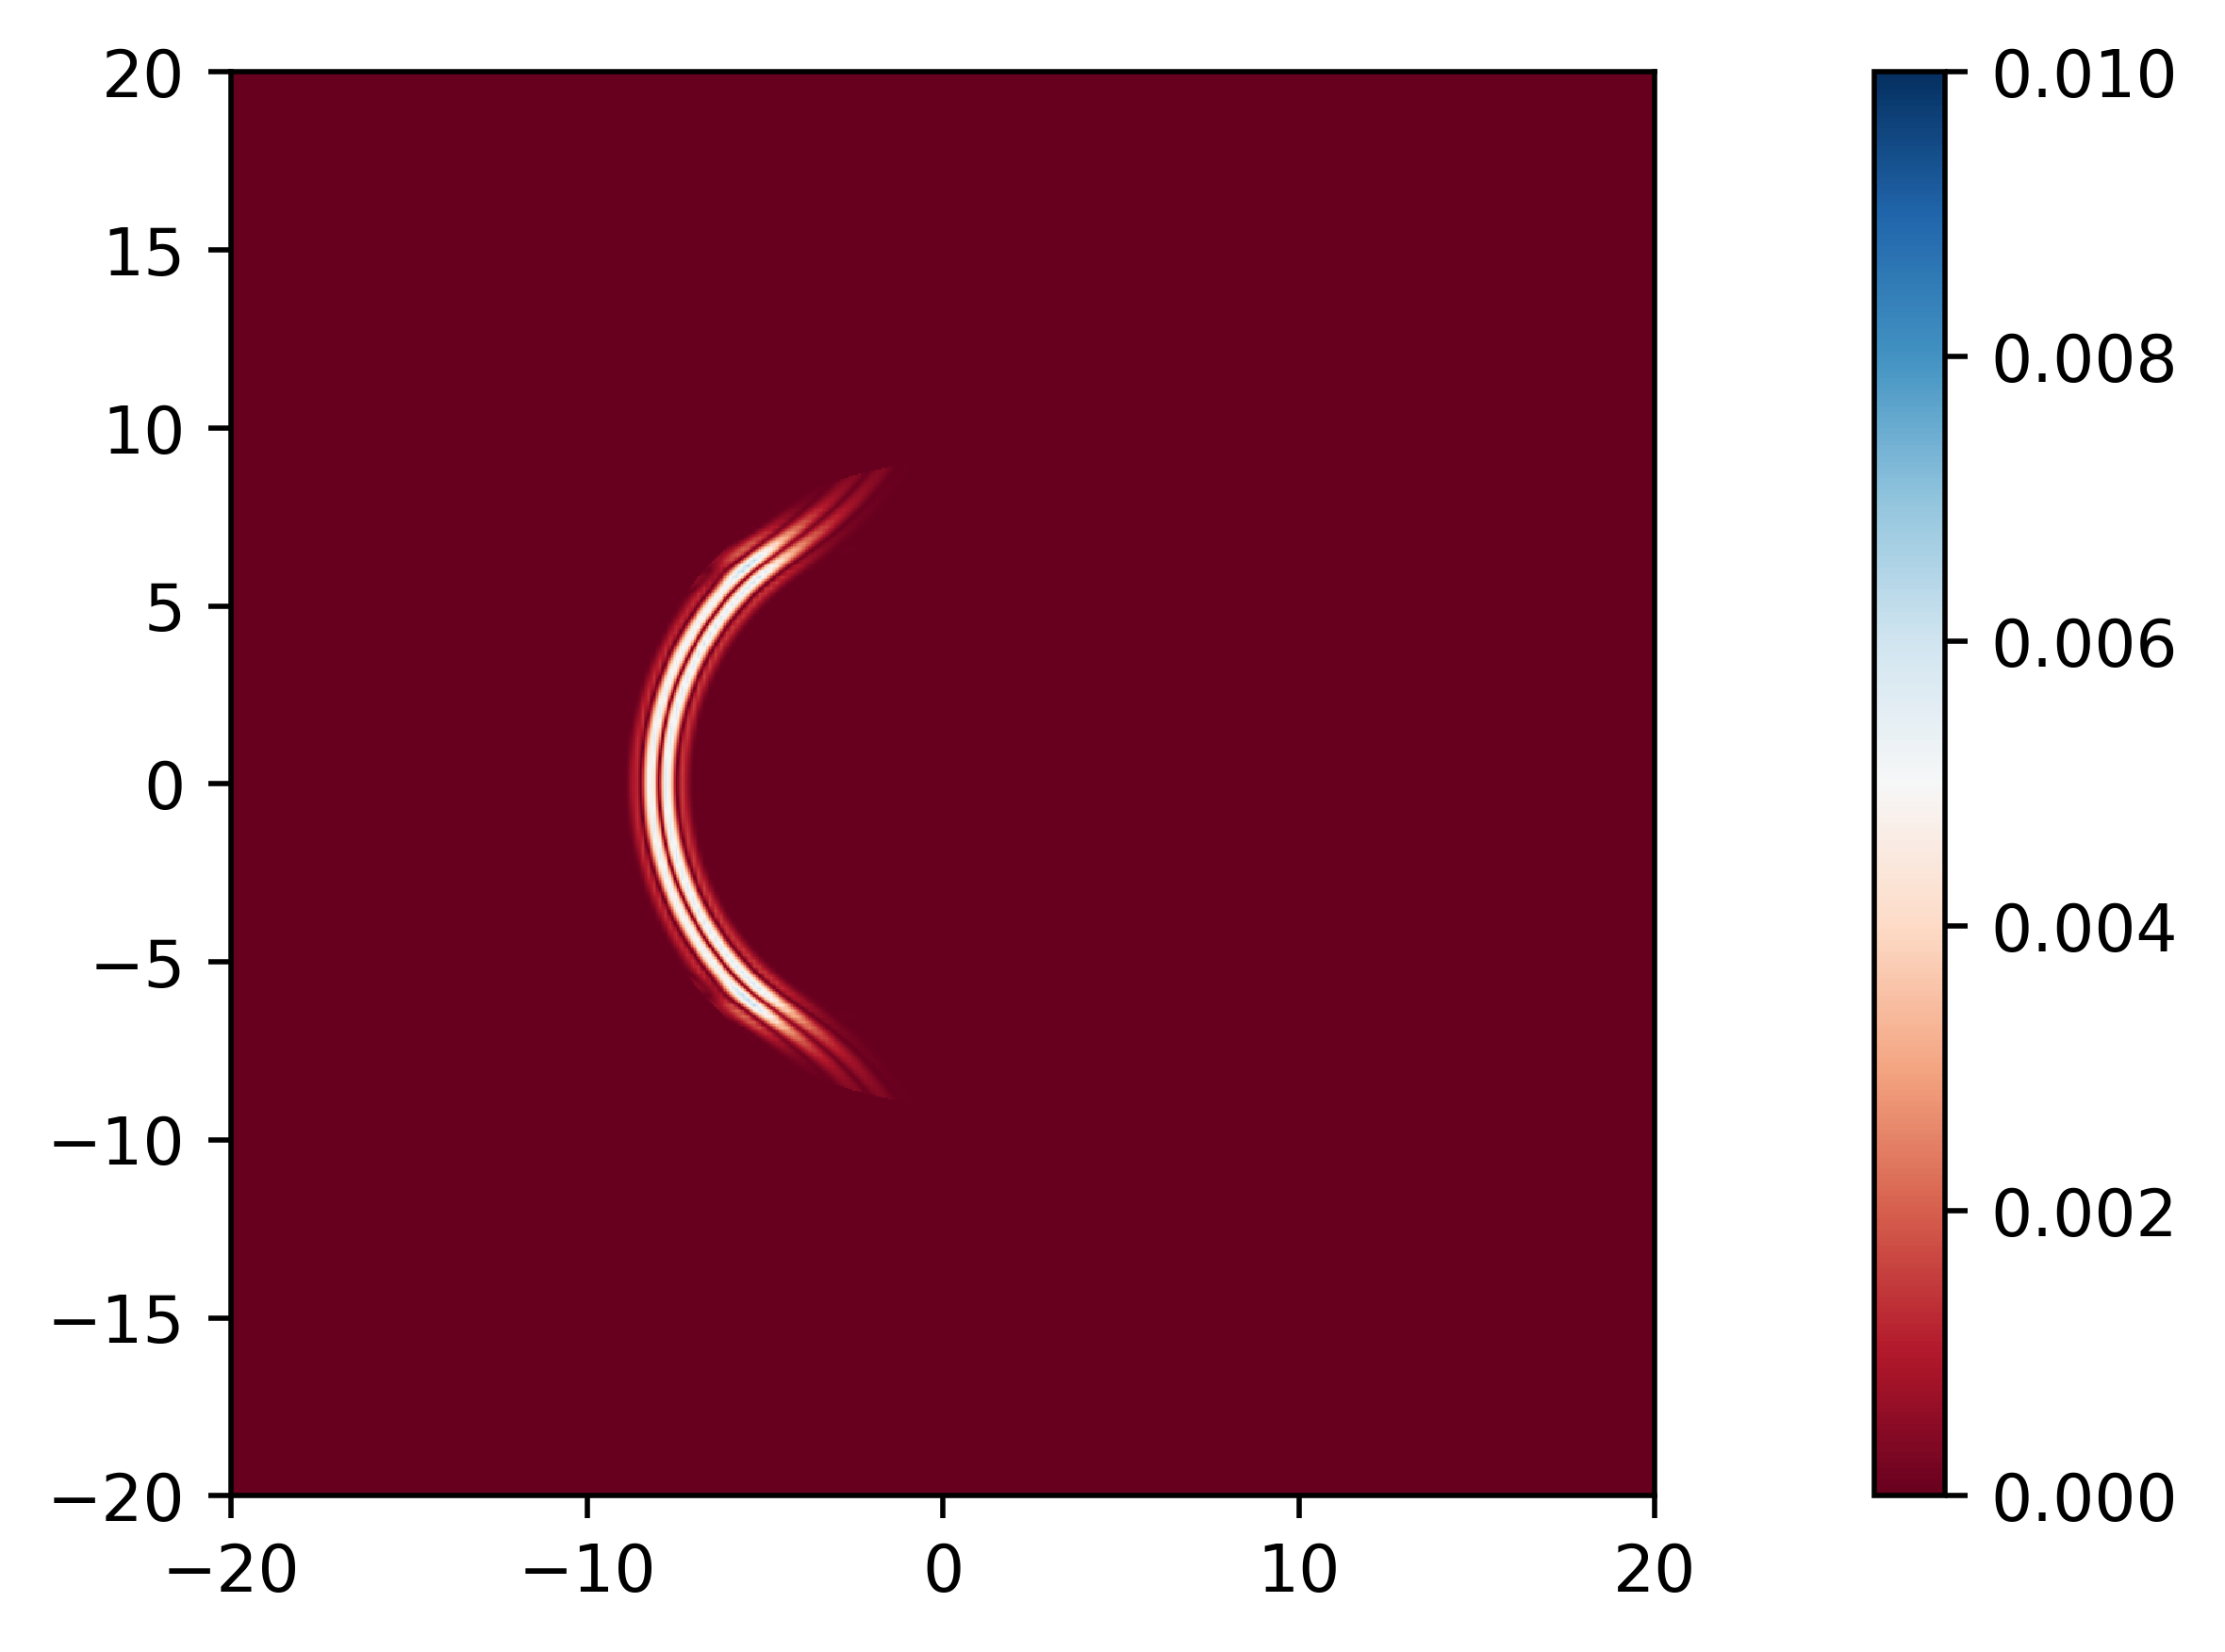

In [34]:
mapping.if_perform_inverse_mapping(True)
plot_im(get_E_norm(field))

The code below determines the peak field value at the time $R_0/c$.

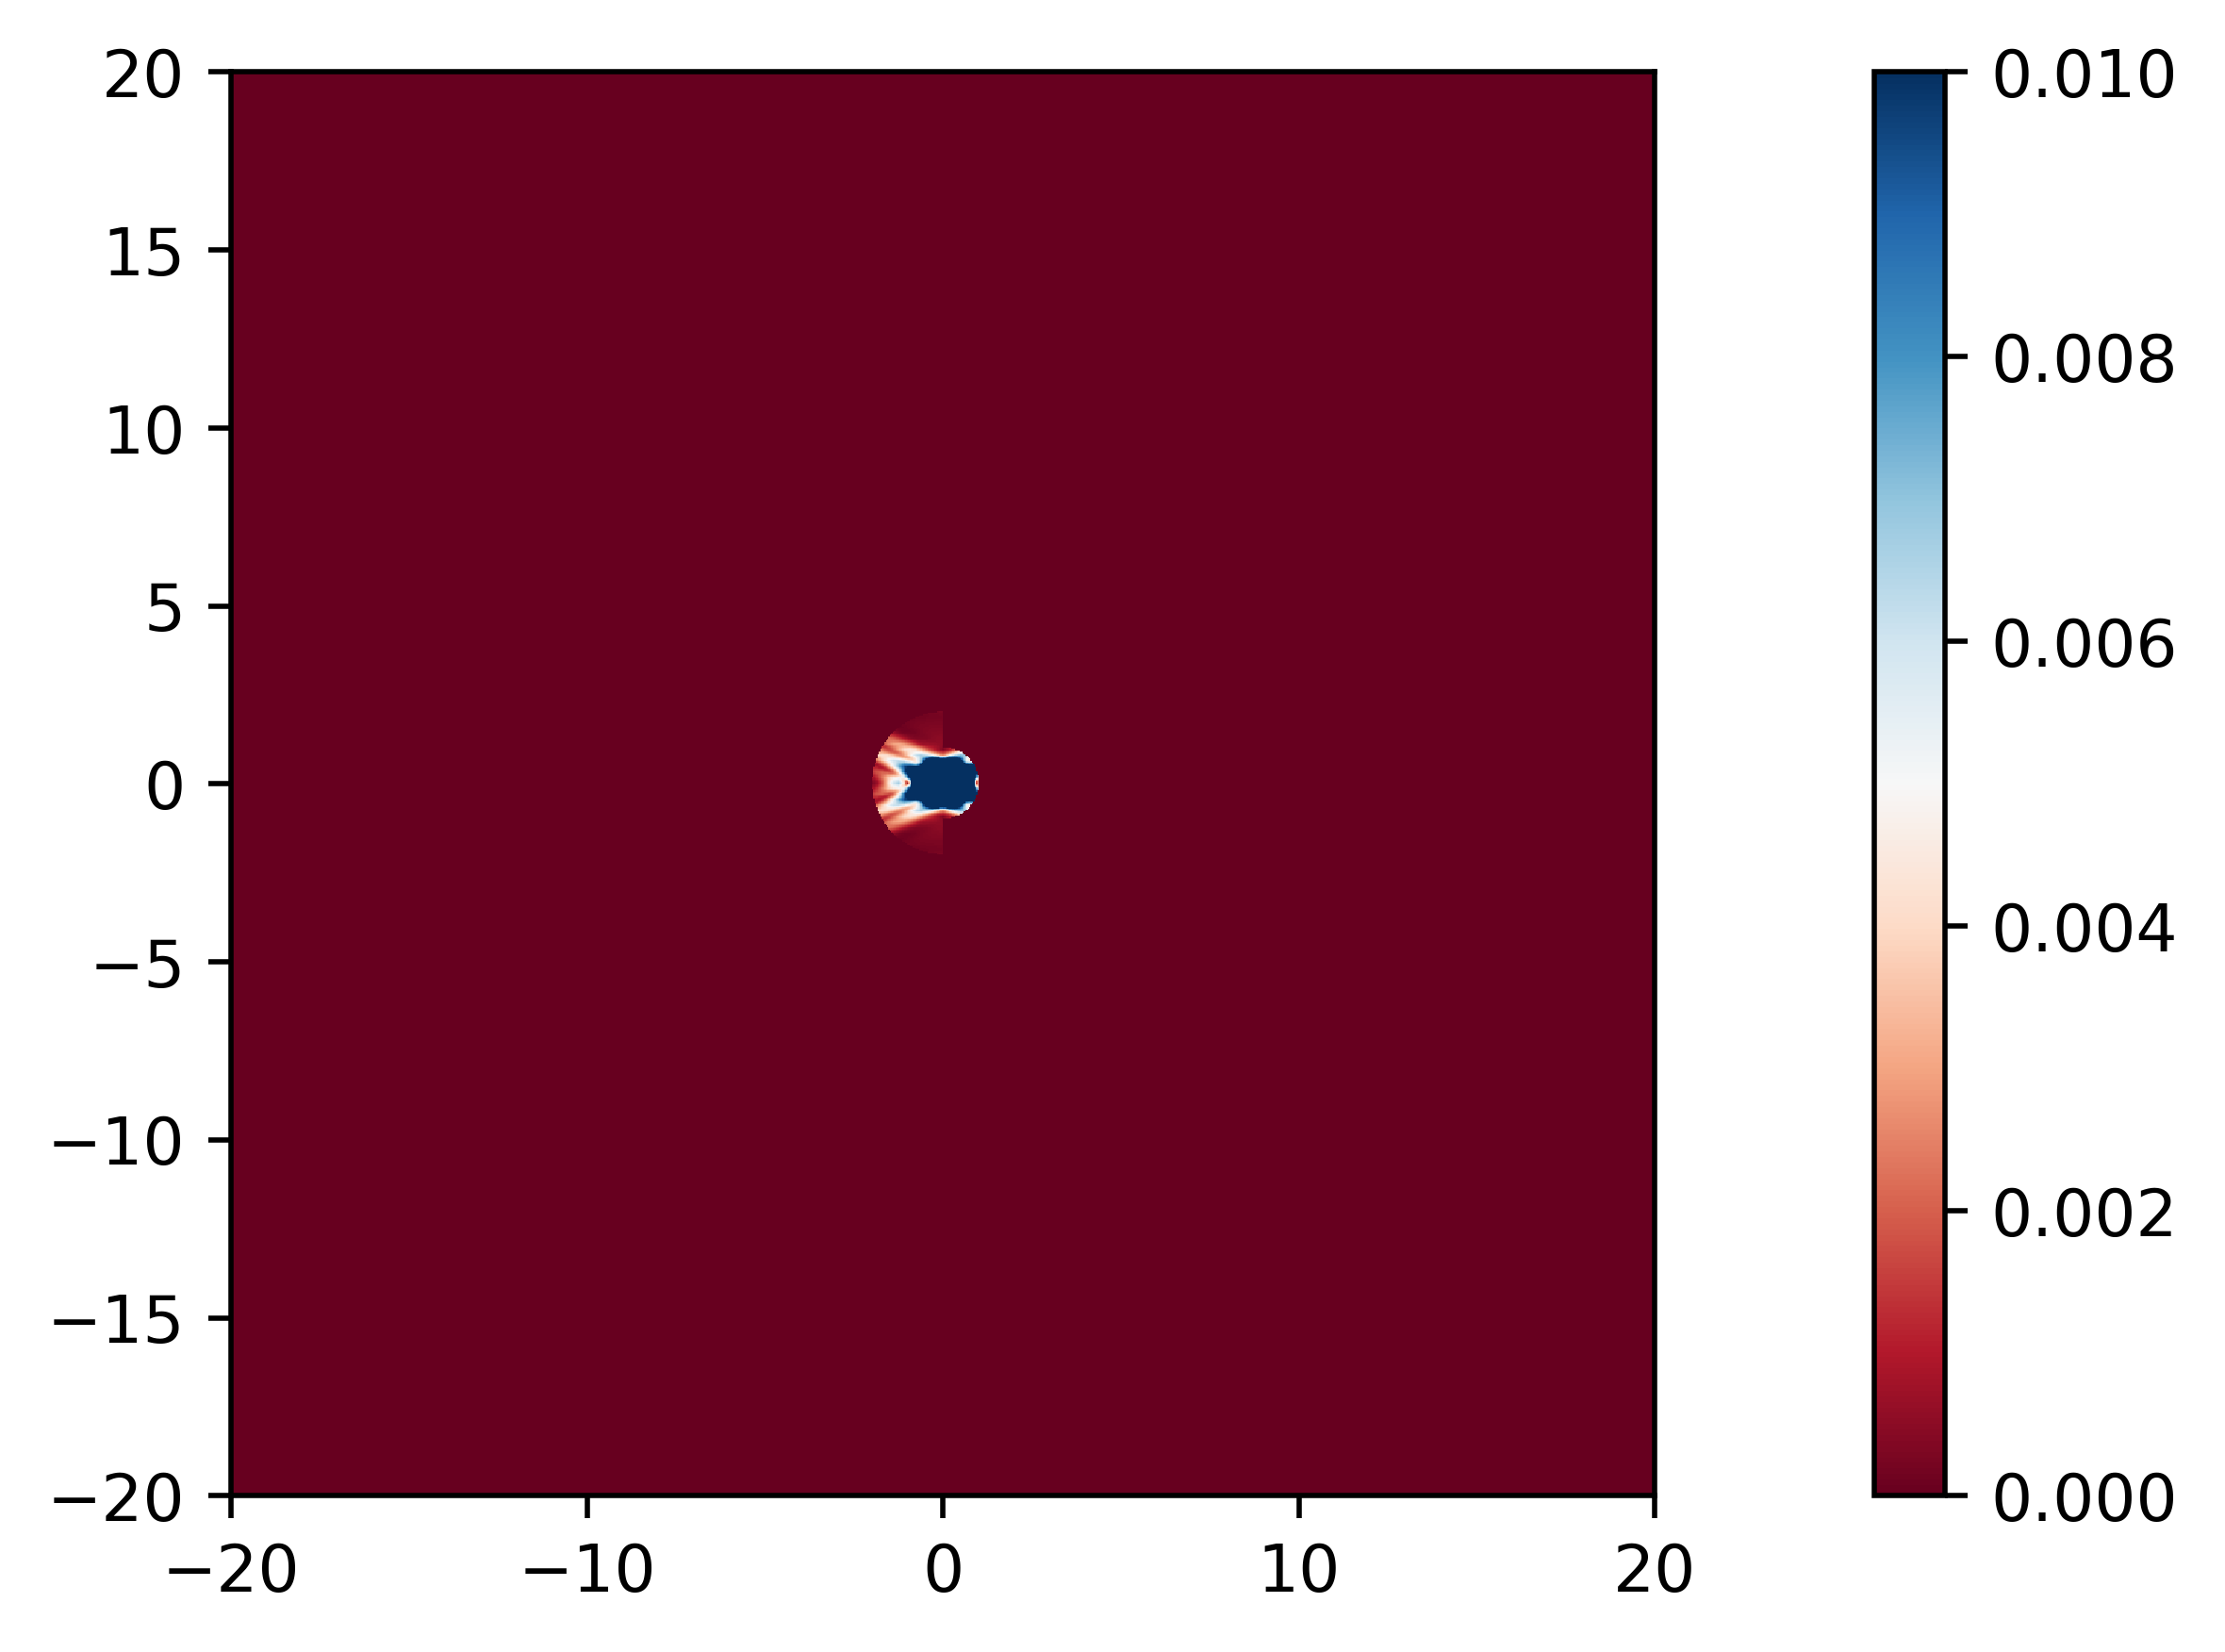

Peak field value is 0.141433


In [35]:
field.update_fields()
field_arr = get_E_norm(field)
plot_im(field_arr)
peak_field_band = field_arr.max()
print("Peak field value is %f" % (peak_field_band))

We can see that when determining the peak field value, the error of the scheme was only 0.02% relative to the simulation in full entire region.

In [36]:
error = abs(peak_field_band - peak_field)/peak_field*100
print(("Error of scheme is %0.3f" % (error)) + "%")

Error of scheme is 0.018%


## Error depending on the band width D

Let us show that the error of the circuit with mapping decreases with increasing bandwidth $D$. The following code lines set an array of points $D$ for which simulation and error calculation will be carried out.

In [37]:
Rmin = R0 - pulselength*0.5
Rmax = R0 + pulselength*0.5
angle = opening_angle + edge_smoothing_angle
Dmin = -Rmin*np.cos(angle) + (Rmax**2 - (Rmin*np.sin(angle))**2)**0.5
Dmax = 10*pulselength

In [38]:
nx_arr = np.linspace(Dmin/grid_step.x, Dmax/grid_step.x, 20).astype(np.int)
D_arr = nx_arr * grid_step.x

The circuit error will be detected when the pulse is focused.

In [39]:
time_step = R0/hichi.c

The following function performs simulation for a fixed grid size along x-axis and returns values of the electric field.

In [40]:
def run(nx):
    # the mapping
    mapping = hichi.TightFocusingMapping(R0, pulselength, nx*grid_step.x)
    
    # the bounds of the band
    x_min = mapping.get_min_coord()
    x_max = mapping.get_max_coord()   
    band_min_coords = hichi.Vector3d(x_min, min_coords.y, min_coords.z)
    band_max_coords = hichi.Vector3d(x_max, max_coords.y, max_coords.z)
    
    # the grid size for the periodic space (that is the real grid size)
    band_grid_size = hichi.Vector3d(nx, grid_size.y, grid_size.z)
    
    # the creation of the computational grid with the approciate mapping
    field = hichi.PSATDPoissonField(band_grid_size, band_min_coords,
                                    grid_step, time_step)
    field = field.apply_mapping(mapping)
    
    # the grid initialisation
    initialize_field(field)
    
    # the performing one iteration of the field solver
    field.update_fields()

    return get_E_norm(field)

In [41]:
res_full = run(grid_size.x)

The error is calculated as the maximum field difference for full and band simulation.

In [42]:
def compute_error(res_band, res_full):
    return np.abs(np.subtract(res_band, res_full)).max()

In a loop, the results are calculated for each parameter value. We can see that error does not exceed 1% and decreases with the $D$ parameter growth.

In [43]:
error_arr = []
for nx in nx_arr:
    res_band = run(nx)
    error_arr.append(compute_error(res_band, res_full))

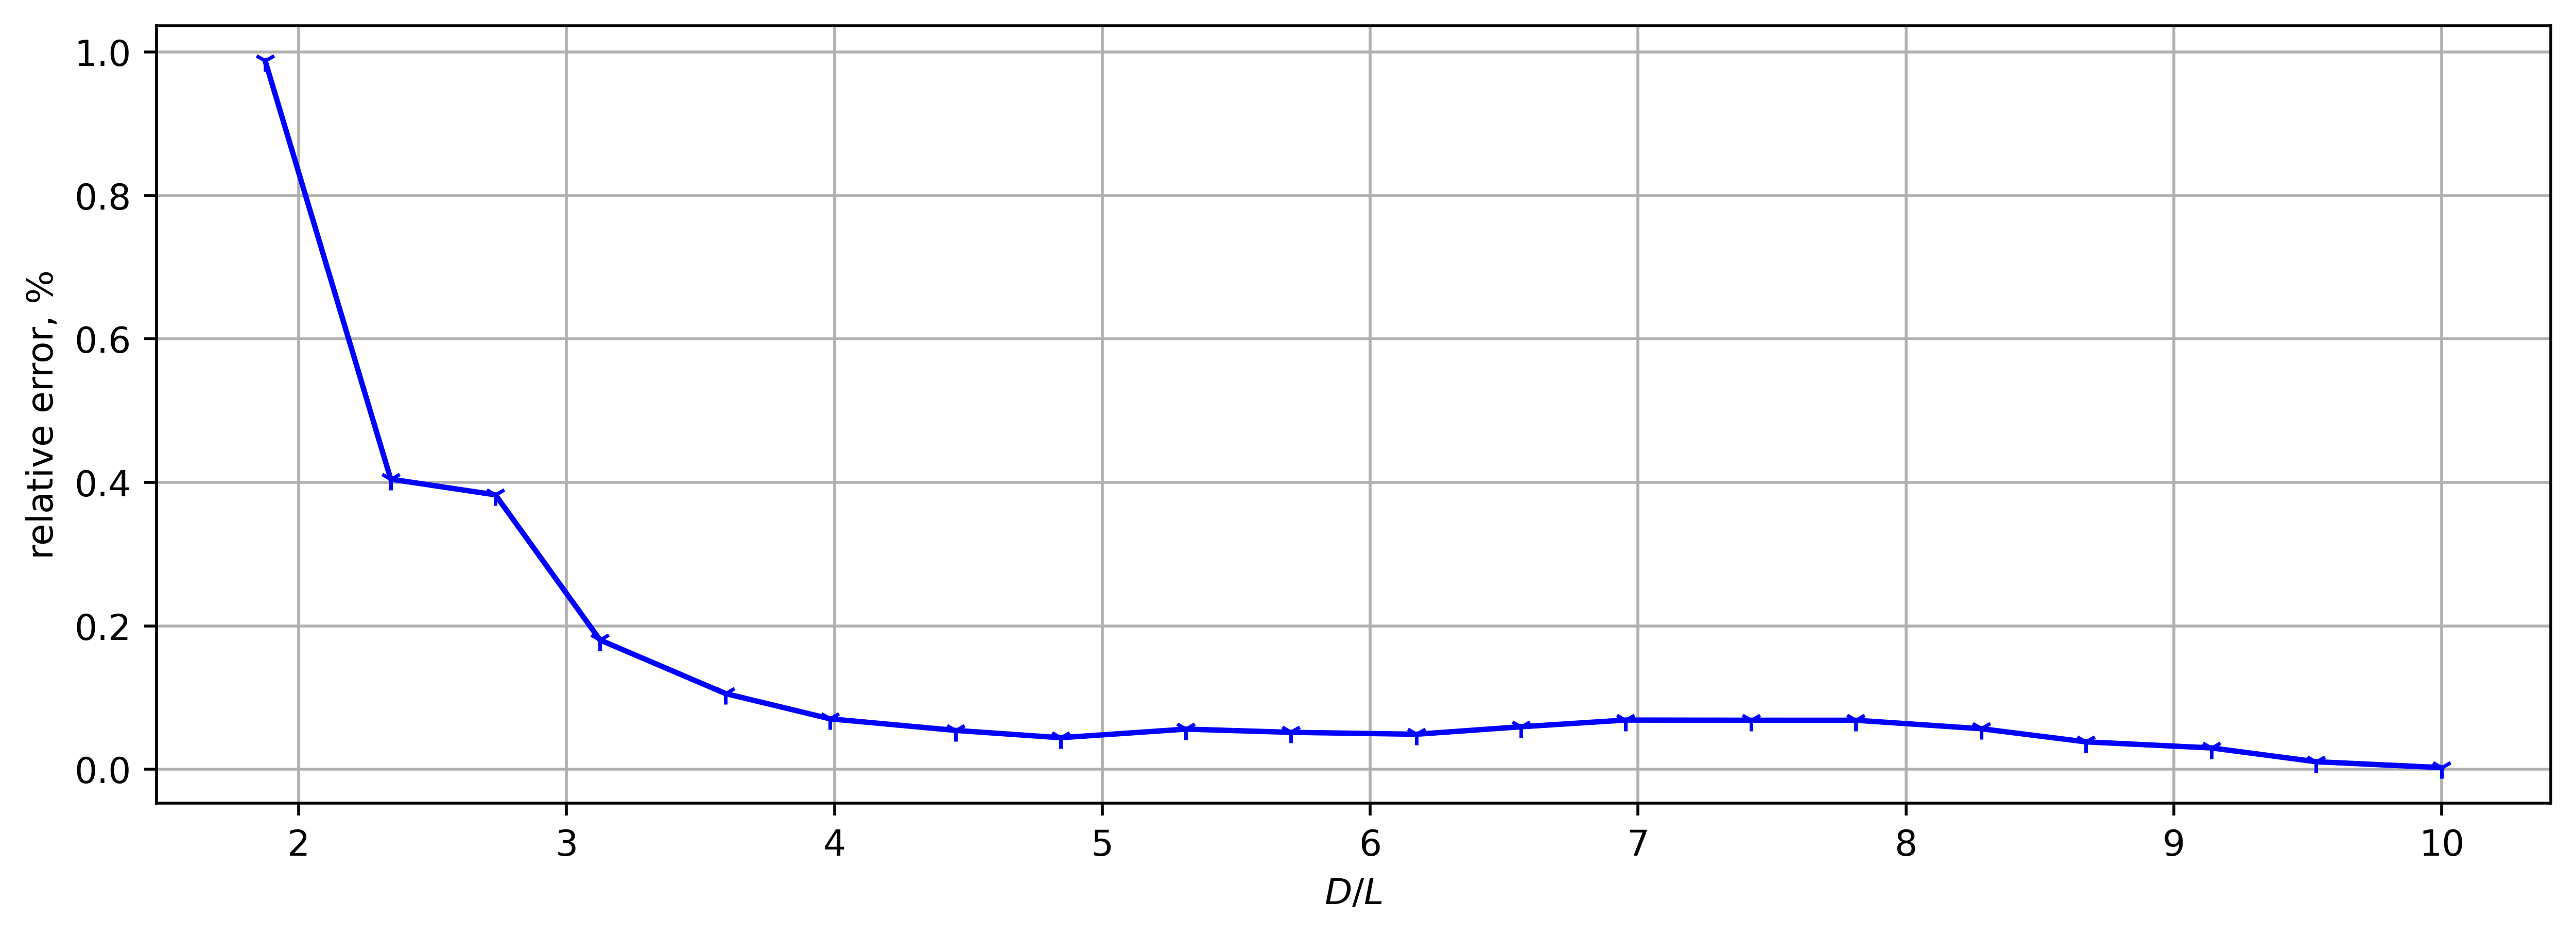

In [44]:
plot_graph(D_arr/pulselength, error_arr/res_full.max()*100,
           "$D/L$", "relative error, %", style="-1b")

## Peak field value depending on f-number

Let us calculate the peak field amplitude depending on the opening angle, or, equivalently, on the f-number, and show, that as the f-number decreases, the focus is located closer to the geometric center, and in this case the highest radiation intensity is achieved.

In [45]:
field = hichi.PSATDPoissonField(band_grid_size, band_min_coords, grid_step, 0.0)
field = field.apply_mapping(mapping)

In [46]:
f_number_arr = np.linspace(0.2, 2.5, 12)

In [47]:
def get_field(field):
    res = np.zeros(shape=(int(grid_size.x)))
    coord = np.arange(min_coords.x, max_coords.x, grid_step.x)
    for ix in range(int(grid_size.x)):
        E = field.get_E(hichi.Vector3d(coord[ix], 0.0, 0.0))
        res[ix] = E.norm()
    return res, coord

In [48]:
def update_fields(field, time_step):
    field.change_time_step(time_step/hichi.c)
    field.update_fields()

The simulation will be performed in two stages. First, some iterations will be performed with a time step of 1.0/hichi.c, then, among the obtained field configurations, the one with the highest intensity of the electromagnetic field will be selected. Finally, in its vicinity a simulation will be performed with a smaller time step 0.1/hichi.c to obtain a more accurate result.

In [49]:
def run_in_time_interval(field, time_start, time_end, time_step):
    res = []
    cur_time = time_start
    while cur_time < time_end:
        field_arr, coord = get_field(field)
        peak = field_arr.max()
        x_peak, = coord[np.where(field_arr == peak)[0]]
        res.append((cur_time, peak, x_peak))
        cur_time += time_step
        update_fields(field, time_step)
    return res

In [50]:
def run(field):
    res = []  # res is a list of touples
              # (time, peak field value, peak coordinate)
    # time step = 1.0/hichi.c
    start_time = 0.0
    final_time = R0
    n_iter = R0
    time_step = (final_time - start_time) / n_iter
    res_interval = run_in_time_interval(field, start_time,
                                        final_time, time_step)
    peak = max(res_interval, key = lambda a: a[1])
    time_max = peak[0]
    res.extend(res_interval)
    
    # time step = 0.1/hichi.c
    eps = 1.0
    start_time = time_max - eps
    update_fields(field, start_time-final_time)
    final_time = time_max + eps
    time_step = 0.1
    res_interval = run_in_time_interval(field, start_time,
                                        final_time, time_step)
    res.extend(res_interval)
    
    res.sort()
    
    return res

Let's perform calculations in a loop and plot the required graphs.

In [51]:
peak_arr = []  # a list of tuples (time, peak field value, peak coordinate)
for f_number_ in f_number_arr:
    initialize_field(field, f_number_=f_number_)
    res = run(field)   
    peak_arr.append(max(res, key=lambda a: a[1]))

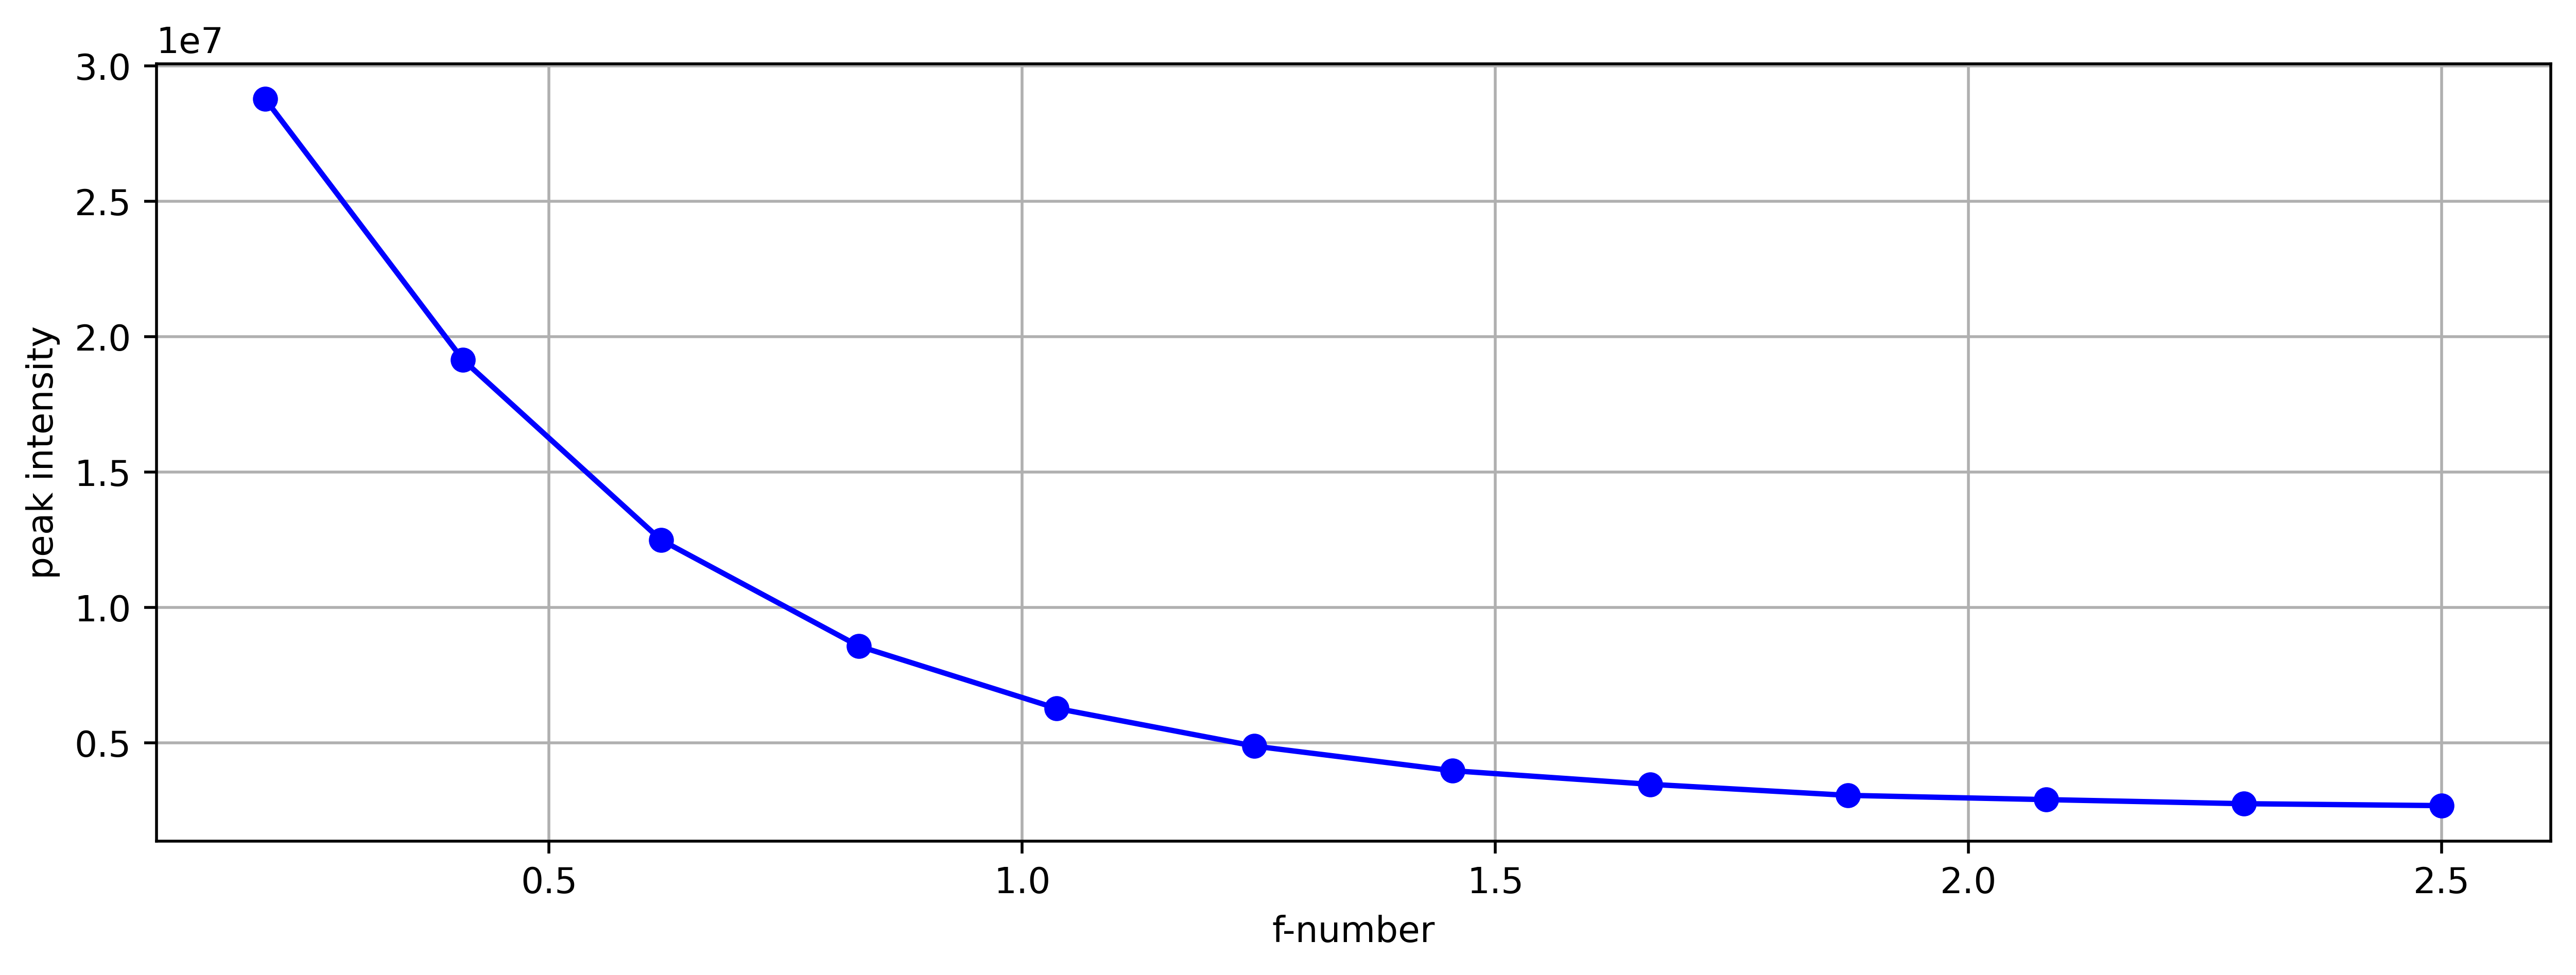

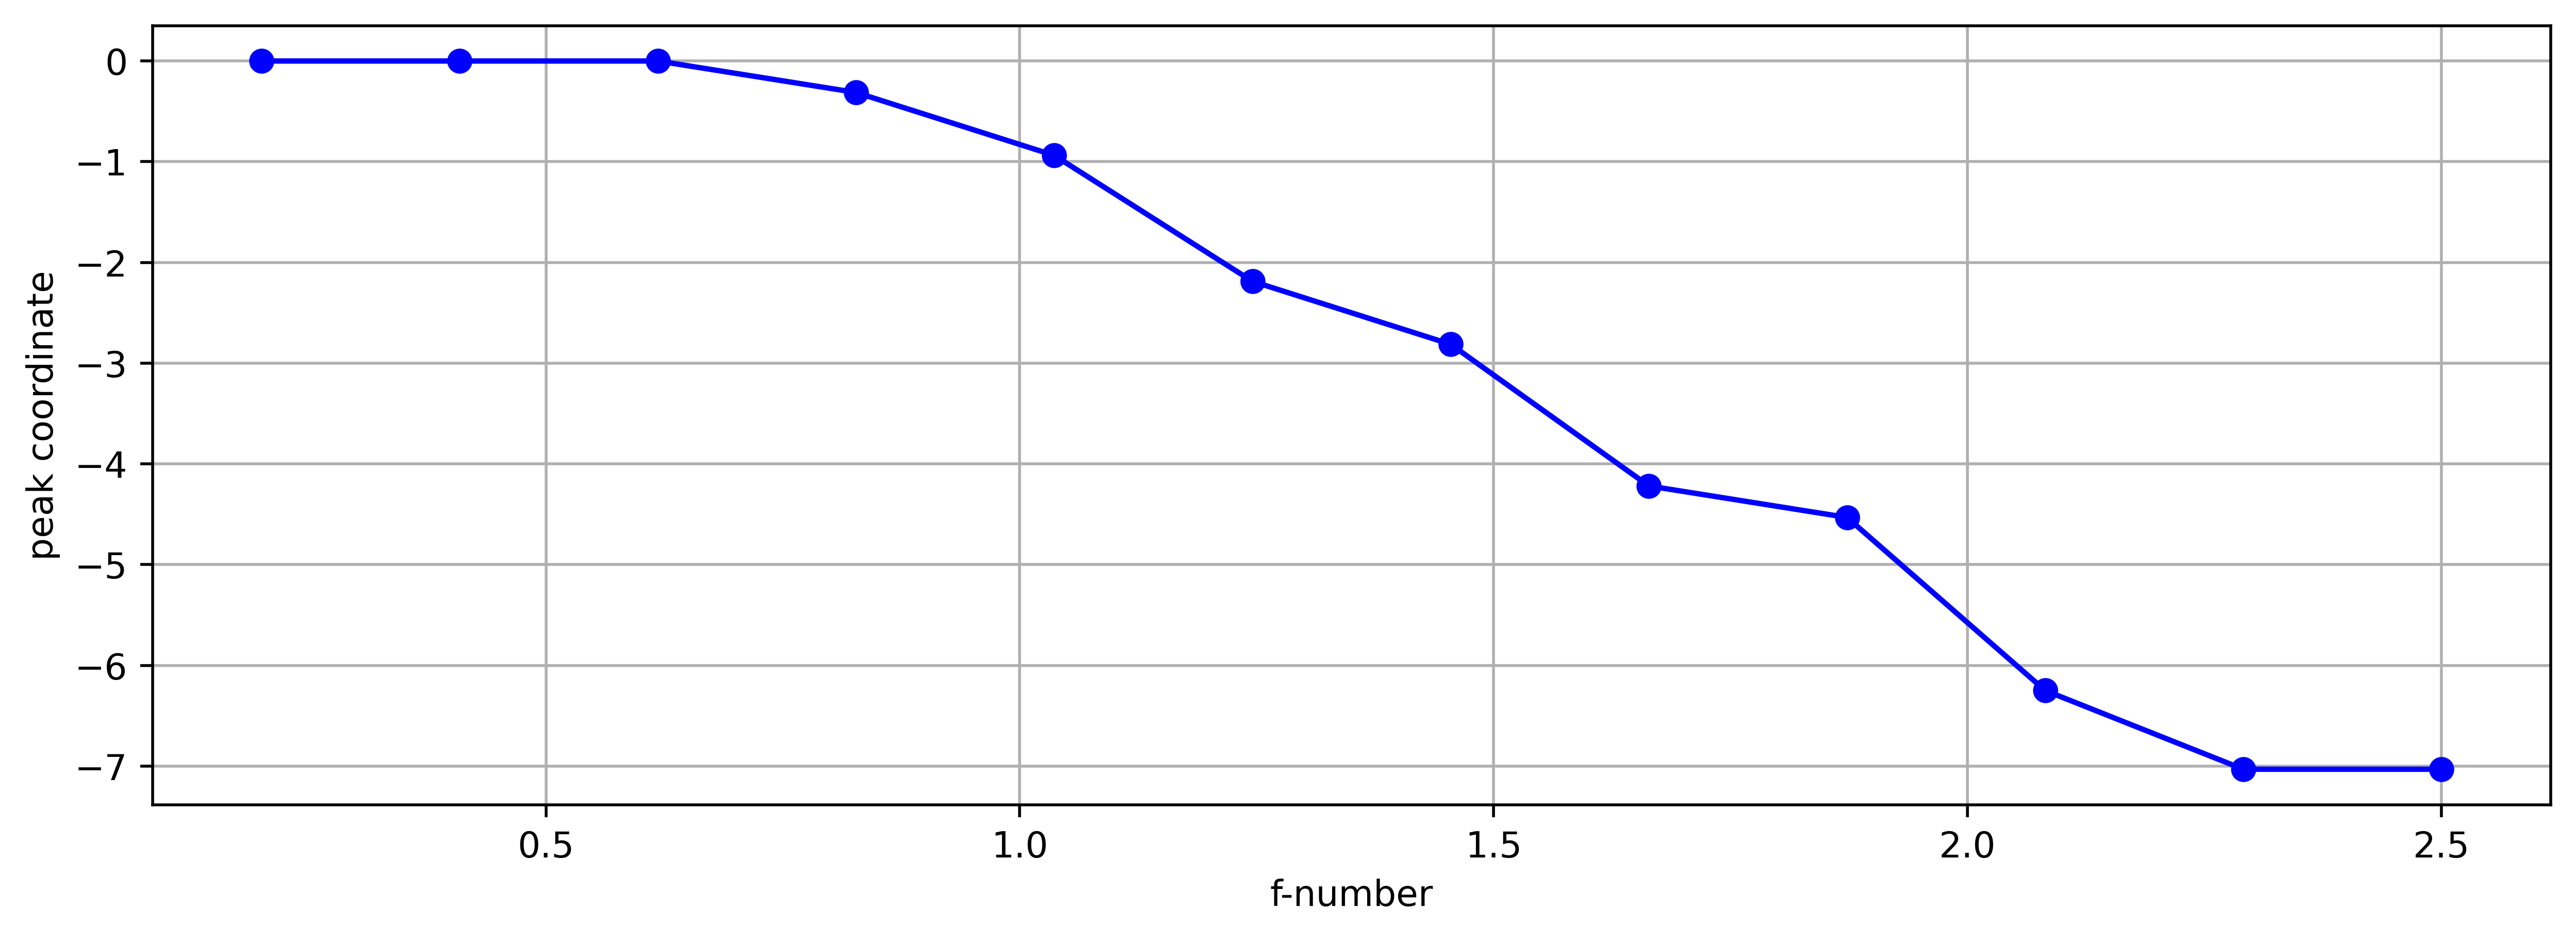

In [52]:
def get_intensity(E):
    return E**2*hichi.c/(8*hichi.pi)

plot_graph(f_number_arr, [get_intensity(elem[1]) for elem in peak_arr],
           'f-number', 'peak intensity', style="-ob")
plot_graph(f_number_arr, [elem[2] for elem in peak_arr],
           'f-number', 'peak coordinate', style="-ob")